### TYK2 IL-23 RNA-seq Assay Sequencing Repeat

In [2]:
library(ggpubr)
library(DESeq2)
library(ggcorrplot)
library(furrr)
library(ggbiplot)
library(patchwork)
library(ComplexHeatmap)
library(tidyverse)

#### Dataset Properties <a name="part1"></a>

In [3]:
alignments <- read_tsv("../pipeline/diffexp/multiqc_data/multiqc_star.txt") %>%
    mutate(id = as.numeric(gsub("_.*", "", Sample)))

count_summary <- read_tsv("../pipeline/diffexp/multiqc_data/multiqc_featureCounts.txt")  %>%
    mutate(id = as.numeric(gsub("_.*", "", Sample)))

Rows: 86 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Sample
dbl (26): uniquely_mapped, num_GCAG_splices, total_reads, multimapped_tooman...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 86 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Sample
dbl (16): Unassigned_FragmentLength, Unassigned_Singleton, Unassigned_NonSpl...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


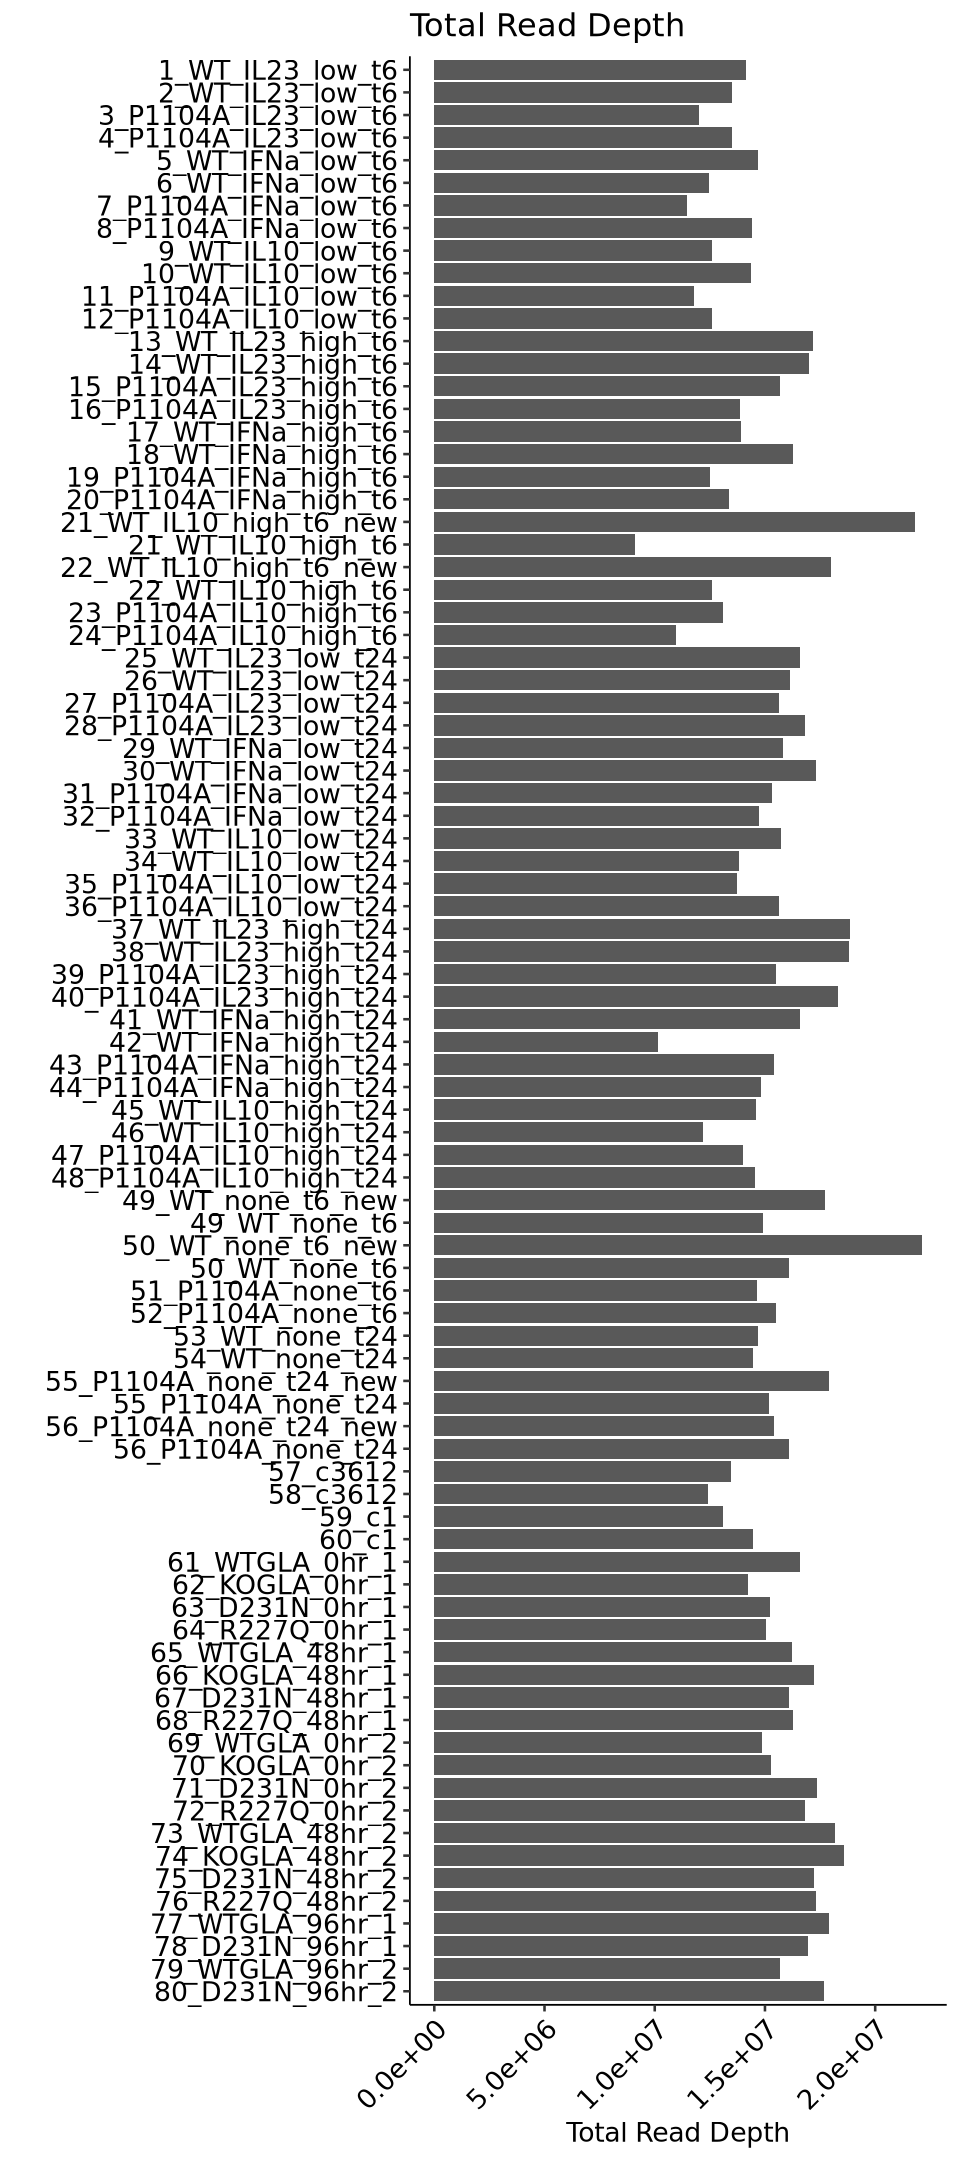

In [4]:
options(repr.plot.width = 8, repr.plot.height = 18)
alignments %>%
    ggplot() +
        geom_bar(aes(x = total_reads, y = reorder(Sample, -id)), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Total Read Depth") + ylab("") +
        ggtitle("Total Read Depth")

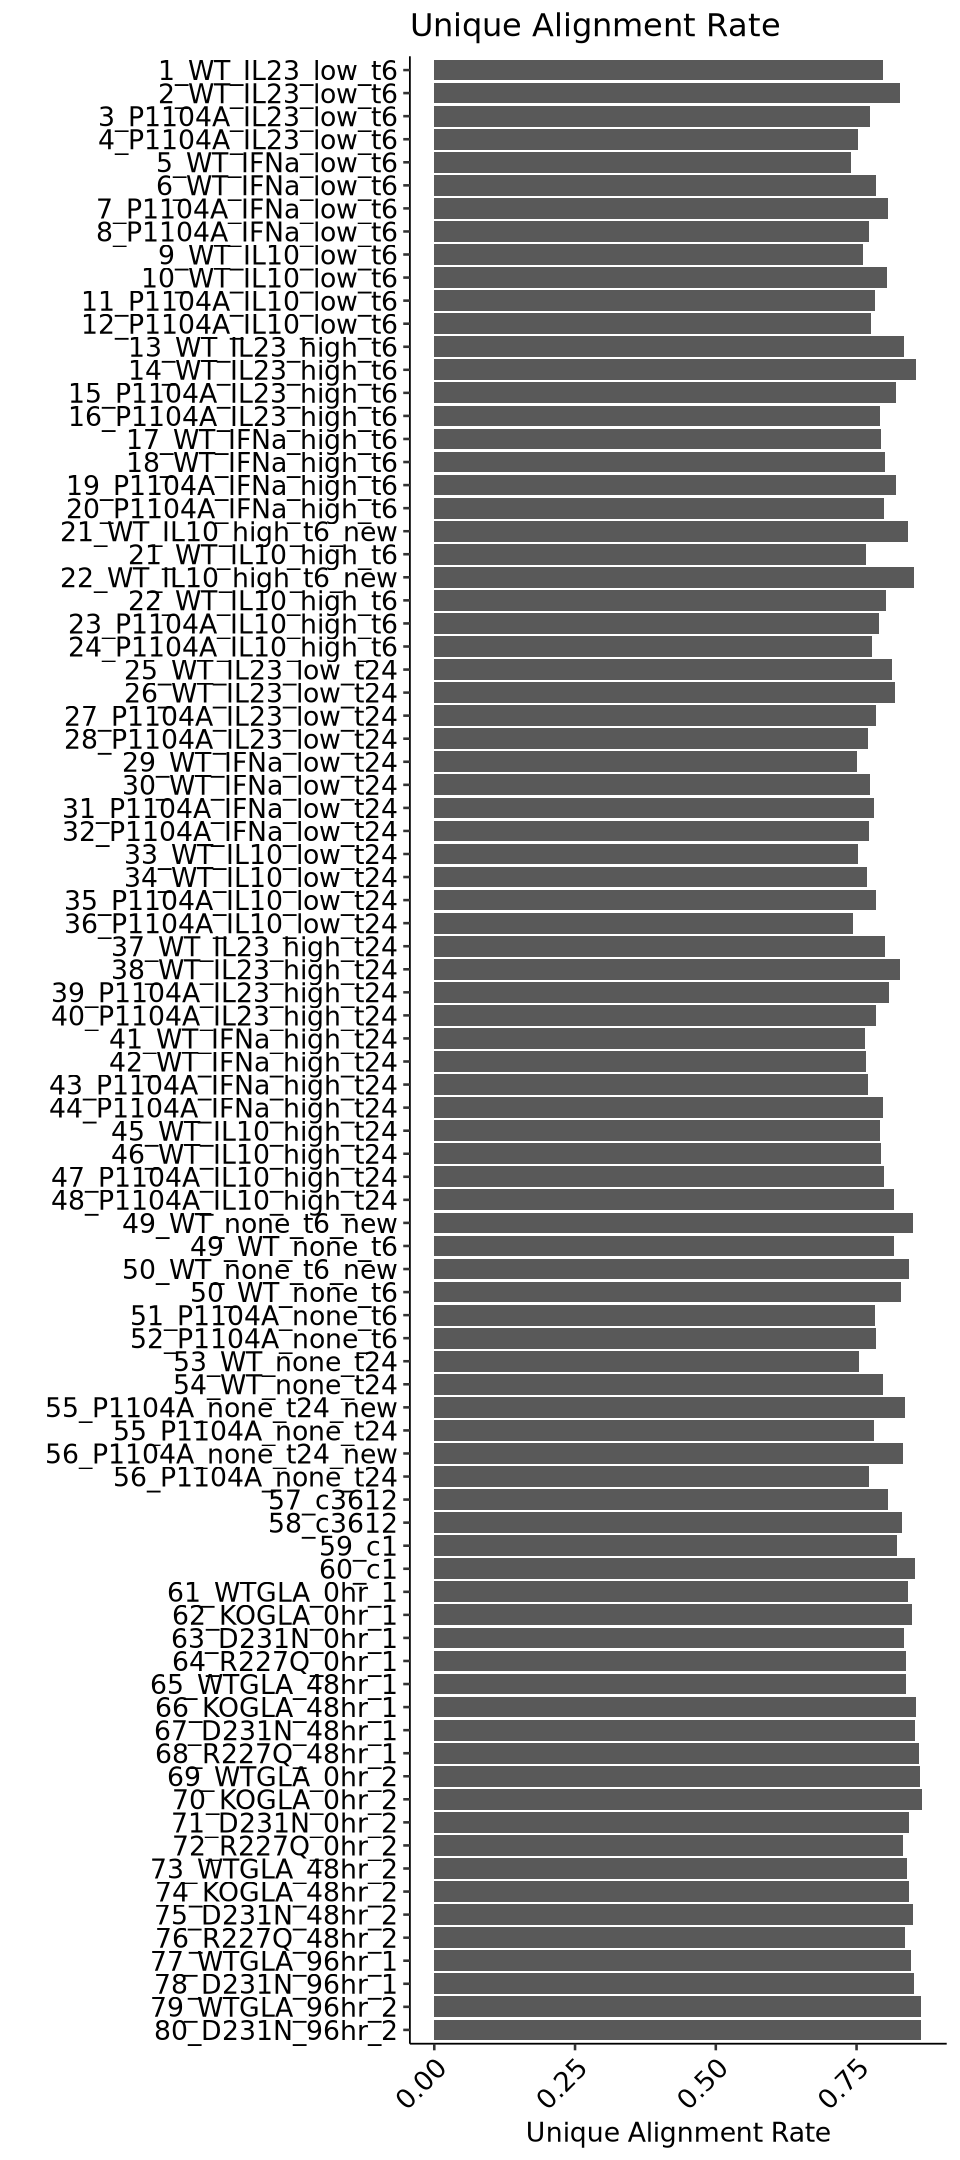

In [5]:
alignments %>%
    ggplot() +
        geom_bar(aes(x = uniquely_mapped_percent/100, y = reorder(Sample, -1*as.numeric(id))), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Unique Alignment Rate") + ylab("") +
        ggtitle("Unique Alignment Rate")

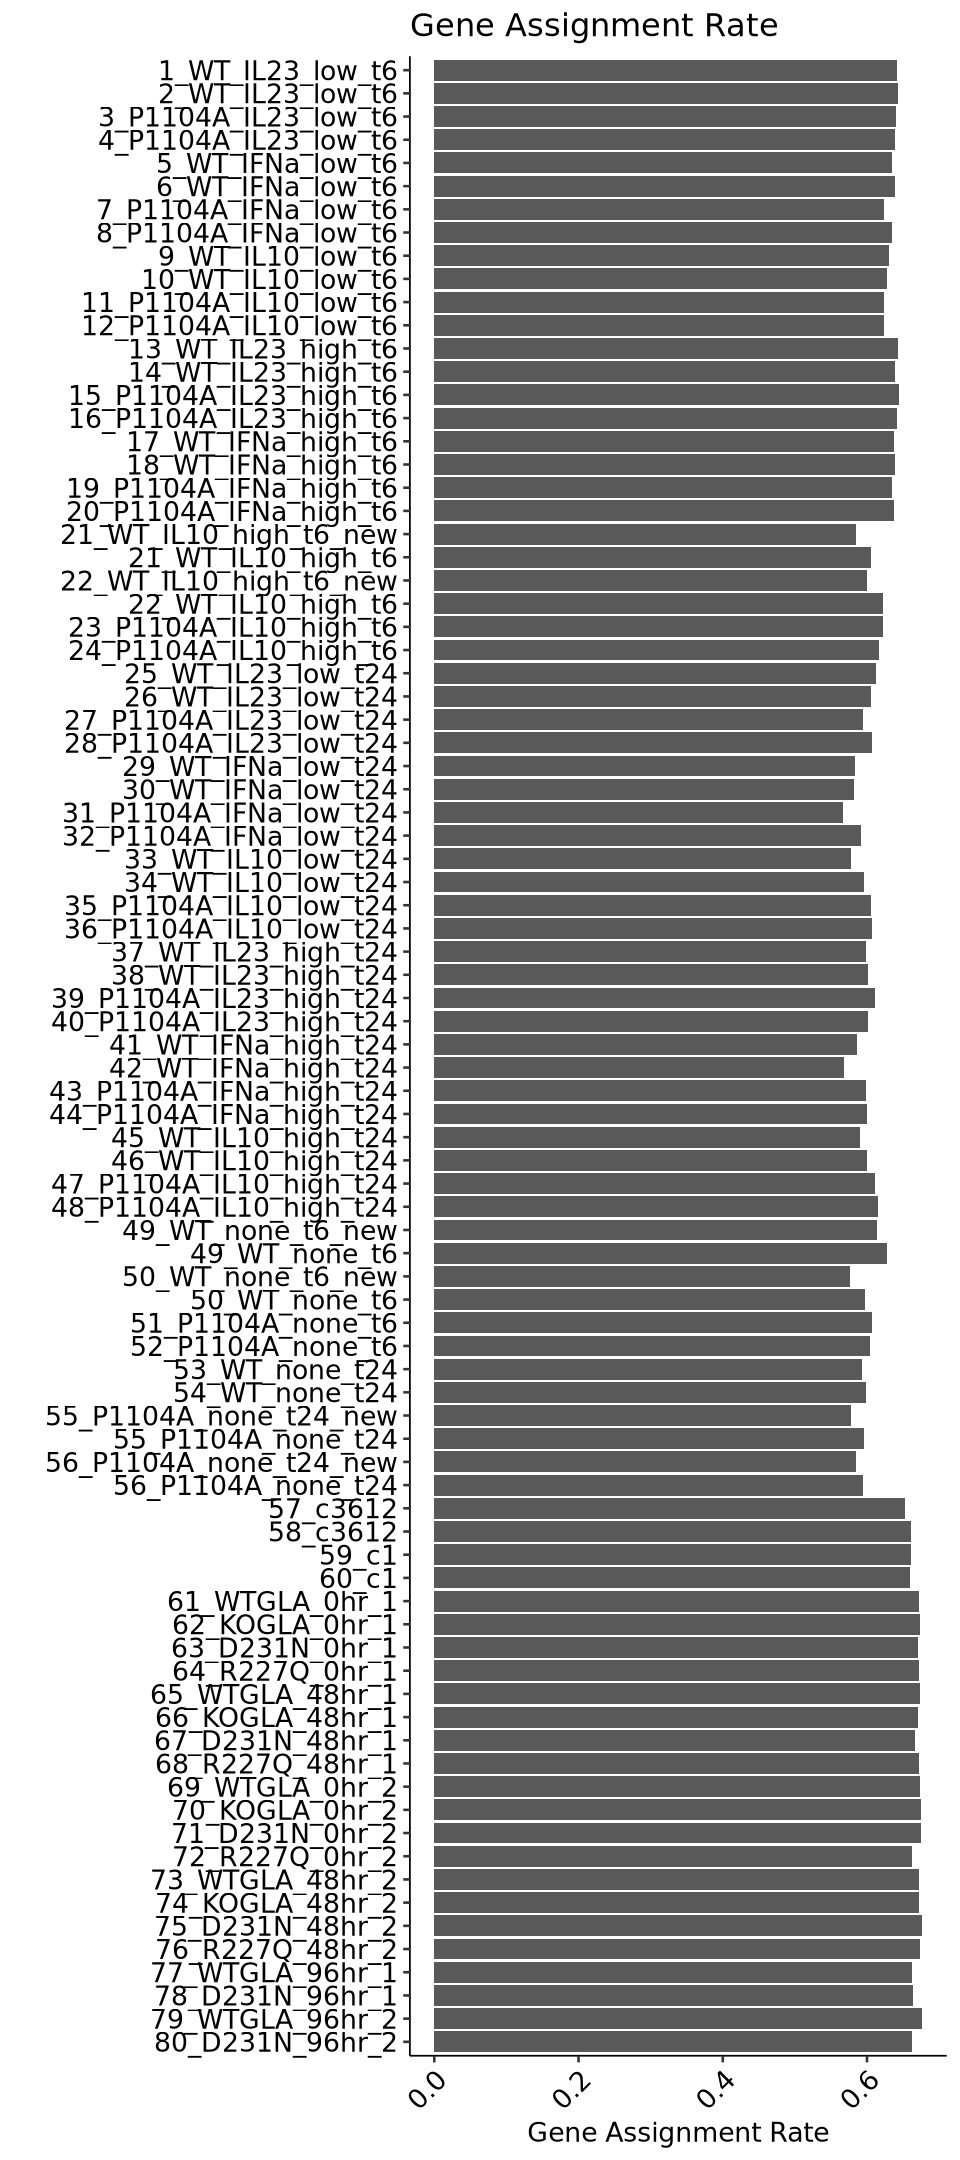

In [6]:
count_summary %>%
    ggplot() +
        geom_bar(aes(x = percent_assigned/100, y = reorder(Sample, -1*as.numeric(id))), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Gene Assignment Rate") + ylab("") +
        ggtitle("Gene Assignment Rate")

#### Unsupervised Profiles <a name="part2"></a>

In [90]:
paths <- str_c("../pipeline/diffexp/",
                    alignments$Sample,
                    ".counts.tsv")
names(paths) <- paths

df <- map_dfr(paths,
              ~read_tsv(.x,
                        col_names = NULL,
                        skip = 2,
                        col_select = c(1,7)),
              .id = "sample") %>%
    rename("gene" = "X1",
           "count" = "X7") %>%
    mutate(sample = gsub("../pipeline/diffexp/|.counts.tsv", "", sample))

df_id <- df %>%
    mutate(id = as.character(gsub("_.*", "", sample)),
           id = if_else(grepl("new", sample), str_c(id, "b"), id)) %>%
    select(-sample) %>%
    arrange(id)

Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────

In [97]:
samp_prop <- read_tsv("../sumstats/RNASEQ/run2/sample-properties-il23.tsv") %>%
    arrange(sample_id) %>%
    mutate(rep = rep(c(1,2), 40),
           covariate = as.factor(str_c(group, "_", cytokine, "_", dosage, "_", time)),
           sample_id = as.character(sample_id))

samp_prop <- bind_rows(

    samp_prop,
    samp_prop %>%
        filter(sample_id %in% c(21, 22, 49, 50, 55, 56)) %>%
        mutate(sample_id = str_c(sample_id, "b"),
               rep = case_when(rep == 1 ~ 3,
                               rep == 2 ~ 4))
    
)

rownames(samp_prop) <- samp_prop$sample_id

Rows: 80 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): group, cytokine, dosage, time
dbl (1): sample_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [100]:
cor_data_wide <- inner_join(df_id, samp_prop, by = c("id" = "sample_id")) %>%
    filter(!is.na(covariate)) %>%
    arrange(cytokine, group, dosage, rep) %>%
    select(gene, covariate, rep, count) %>%
    pivot_wider(names_from = covariate:rep, values_from = count)

cor_data_wide$v <- rowMeans(as.matrix(cor_data_wide[,-1]), na.rm = TRUE)

cor_data_filt <- cor_data_wide %>%
    arrange(-v) %>%
    head(1000) %>%
    select(-gene, -v)

cor_mat <- cor(cor_data_filt, use = "pairwise.complete.obs")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


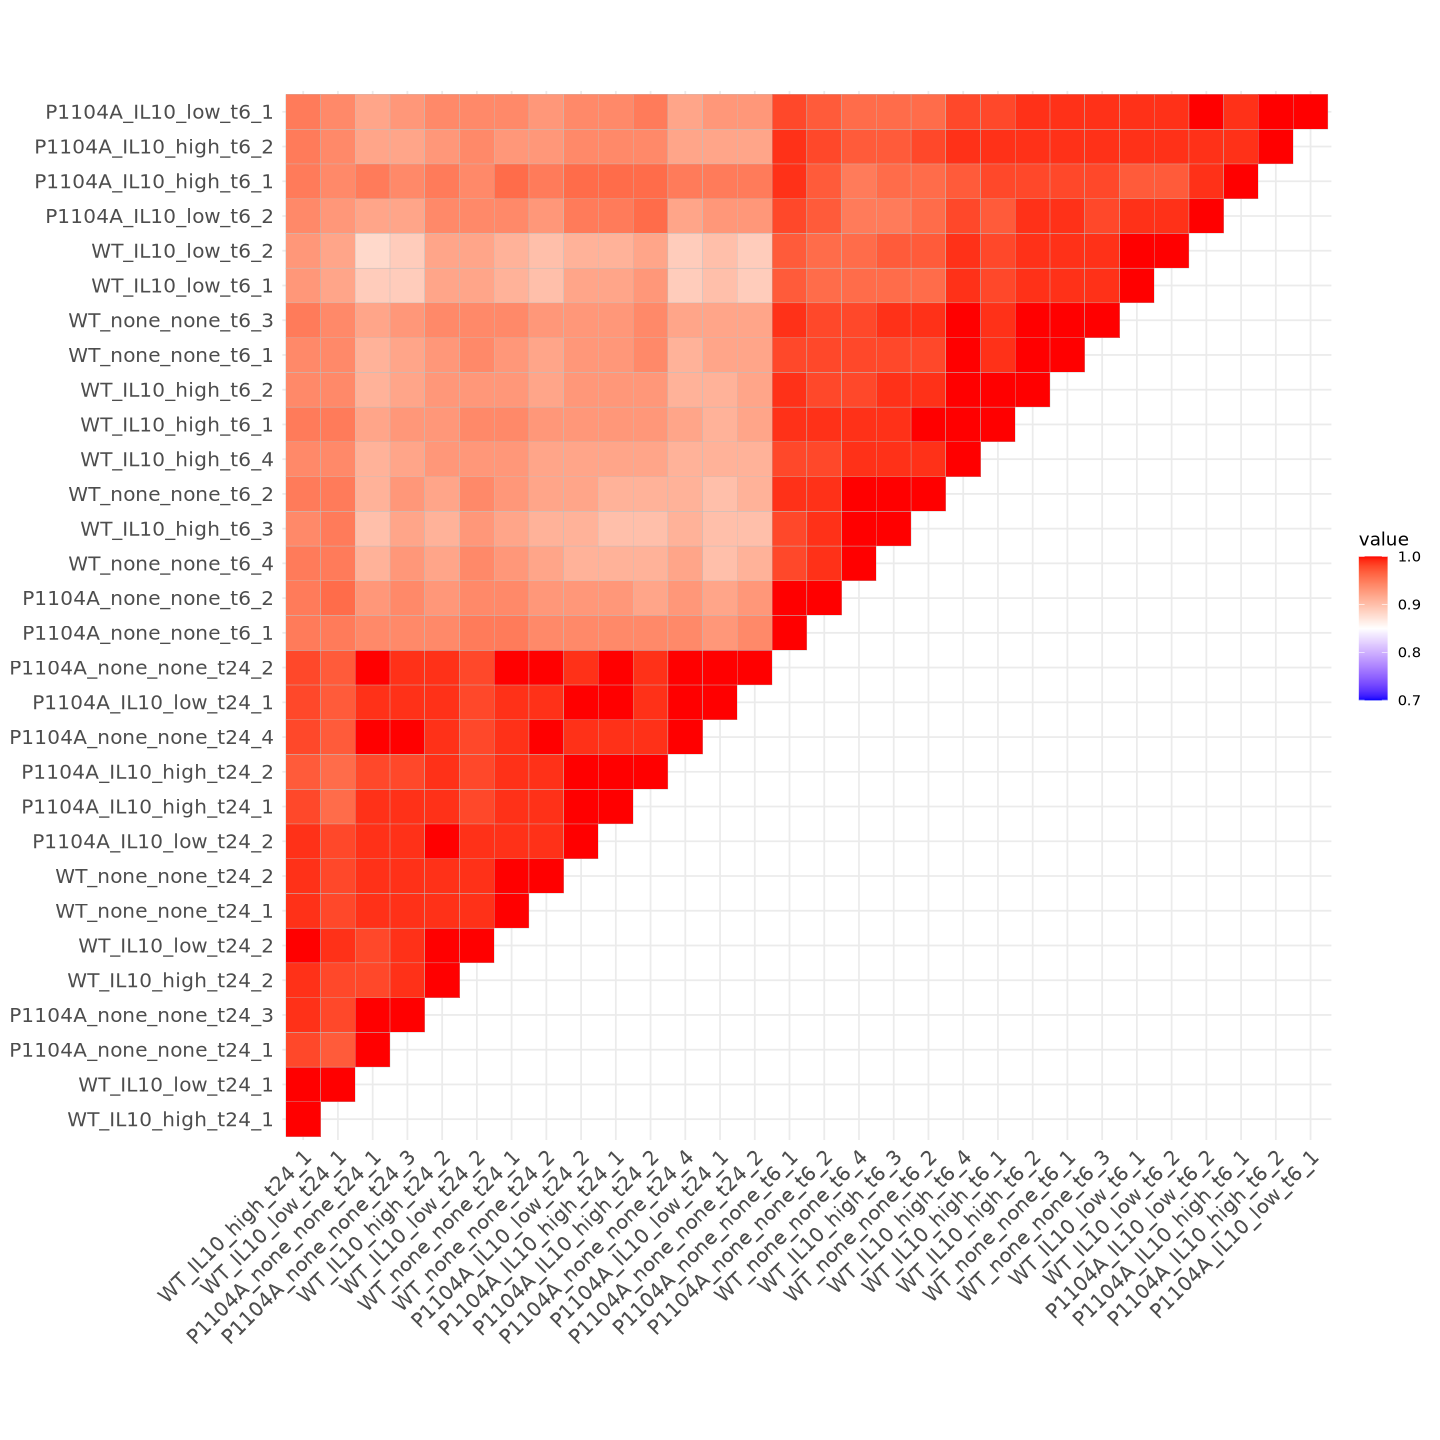

In [101]:
options(repr.plot.width = 12, repr.plot.height = 12)
ggcorrplot(cor_mat[idx,idx], hc.order = TRUE, type = "upper", show.diag = TRUE) +
    scale_fill_gradient2(limit = c(0.7,1), low = "blue", high =  "red", mid = "white", midpoint = 0.85)

#### Statistical Modeling <a name="part3"></a>

In [144]:
de_prop <- samp_prop %>%
    filter(!is.na(cytokine)) %>%
    arrange(covariate)
rownames(de_prop) <- str_c(de_prop$covariate, "_", de_prop$rep)

de_data <- df_id %>%
    inner_join(de_prop %>% select(sample_id, covariate, rep), by = c("id" = "sample_id")) %>%
    select(-id) %>%
    filter(!is.na(covariate)) %>%
    arrange(covariate, rep) %>%
    pivot_wider(names_from = covariate:rep, values_from = count)

log2_cpm <- de_data %>%
    pivot_longer(names_to = "sample", values_to = "count", -gene) %>%
    group_by(sample) %>%
    mutate(count = log2(count * 1000000 / sum(count, na.rm = TRUE)),
           count = if_else(is.infinite(count), NA, count)) %>%
    pivot_wider(names_from = sample, values_from = count)

write_tsv(de_data, "../sumstats/RNASEQ/run3/raw-counts.tsv")
write_tsv(log2_cpm, "../sumstats/RNASEQ/run3/log2-cpm.tsv")

In [146]:
deobj_counts <- DESeqDataSetFromMatrix(countData = de_data %>% select(-gene),
    colData = de_prop,
    design = ~covariate)

deresult <- DESeq(deobj_counts)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [147]:
cov_group <- de_prop %>%
    filter(!grepl("none", covariate)) %>%
    distinct(covariate) %>%
    pull(covariate) %>%
    as.character()

none_group <- gsub("IFNa|IL10|IL23|low|high", "none", cov_group) %>%
    as.character()

plan(multicore, workers = 25)
norm_result <- future_map2(.x = cov_group,
                    .y = none_group,
                    ~results(deresult,
                             contrast = c("covariate", .x, .y),
                             independentFiltering = FALSE))

sumstats <- map2_dfr(norm_result,
                     cov_group,
                     ~bind_cols("gene" = de_data$gene,
                                            as_tibble(.x),
                                            "condition" = .y))

sumstats %>%
    separate(condition, c("background", "cytokine", "dosage", "time"), "_") %>%
    write_tsv("../sumstats/RNASEQ/run3/deseq2-sumstats-vs-none.tsv")

In [150]:
sumstats <- read_tsv( "../sumstats/RNASEQ/run3/deseq2-sumstats-vs-none.tsv.gz")
split_sumstats <- sumstats %>%
    mutate(group = case_when(padj == 1 ~ "FDR = 1",
                             padj < 0.01 ~ "FDR < 0.01",
                             TRUE ~ "NS")) %>%
    mutate(time = relevel(as.factor(time), ref = "t6"),
           dosage = relevel(as.factor(dosage), ref = "low"))

ma_grid <- split_sumstats %>%
    ggplot() +
        geom_point(aes(x = log2(baseMean),
                       y = log2FoldChange,
                       color = group)) +
        theme_pubr(base_size = 15) +
        facet_grid(rows = vars(dosage, time),
                   cols = vars(cytokine, background)) +
        scale_color_manual(values = c("FDR = 1" = "gray",
                                      "NS" = "black",
                                      "FDR < 0.01" = "red"))

Rows: 1454568 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): gene, background, cytokine, dosage, time
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


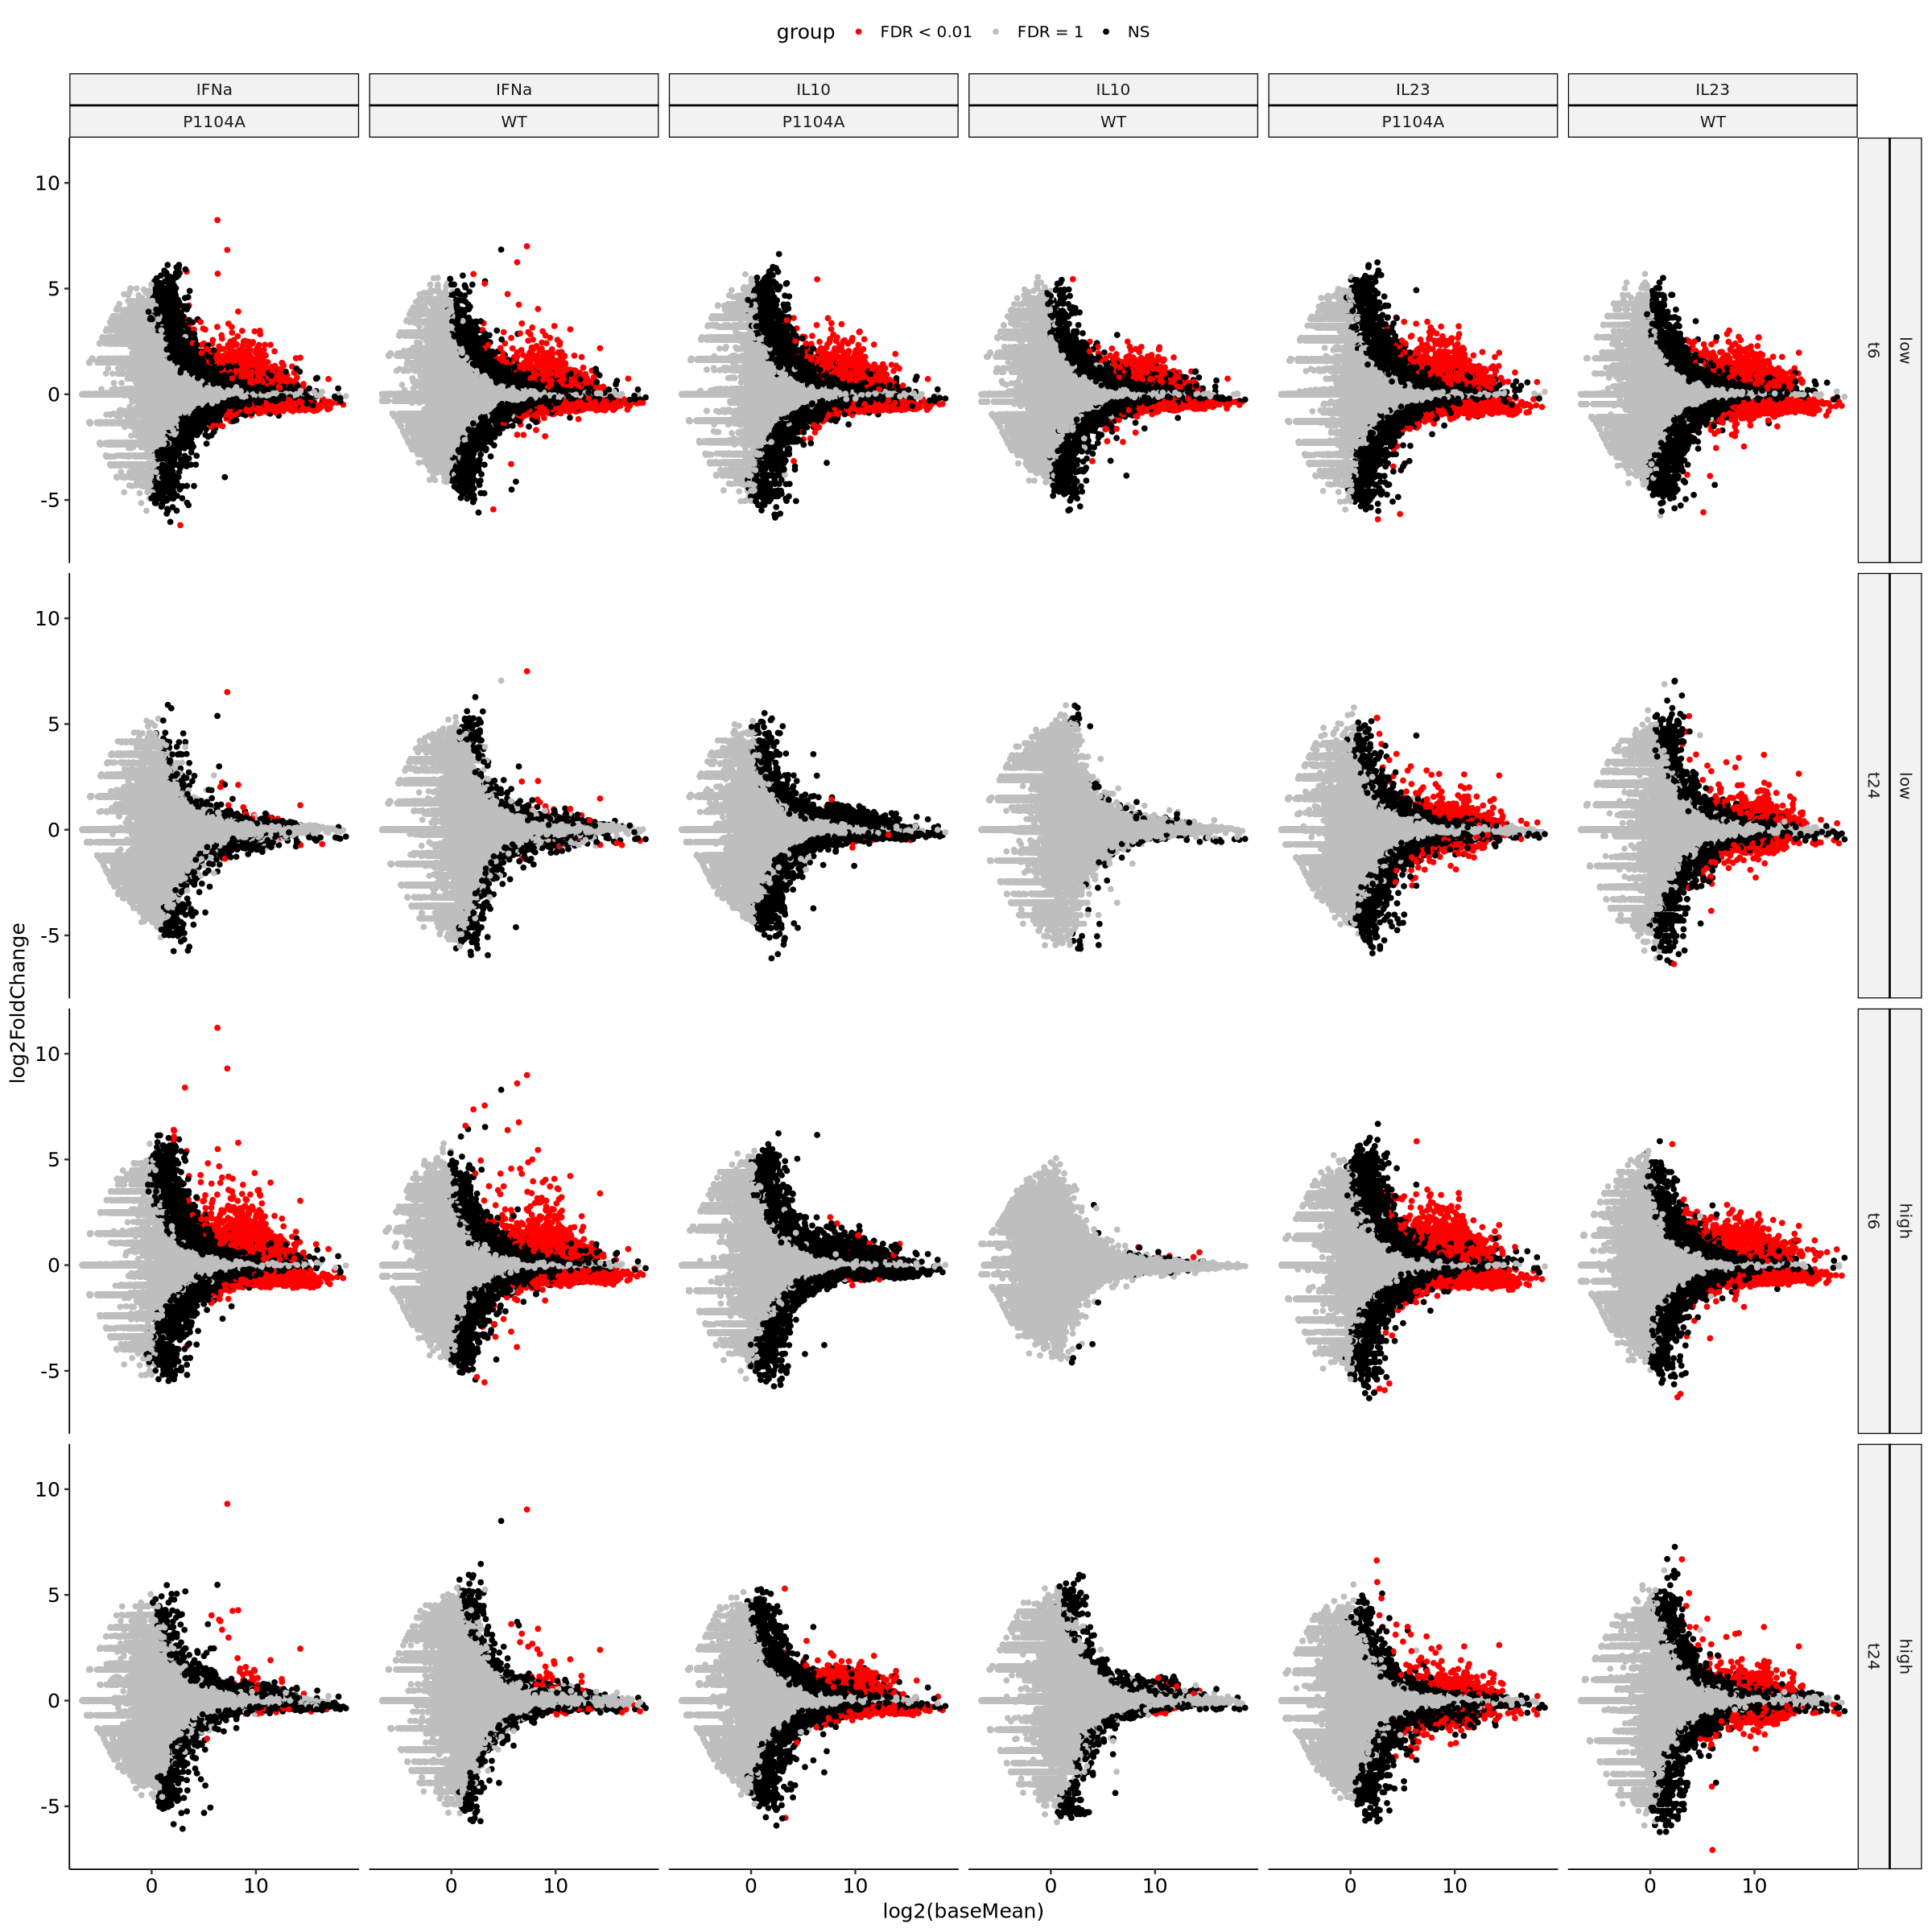

In [151]:
options(repr.plot.width = 20, repr.plot.height = 20, warn = -1)
ma_grid

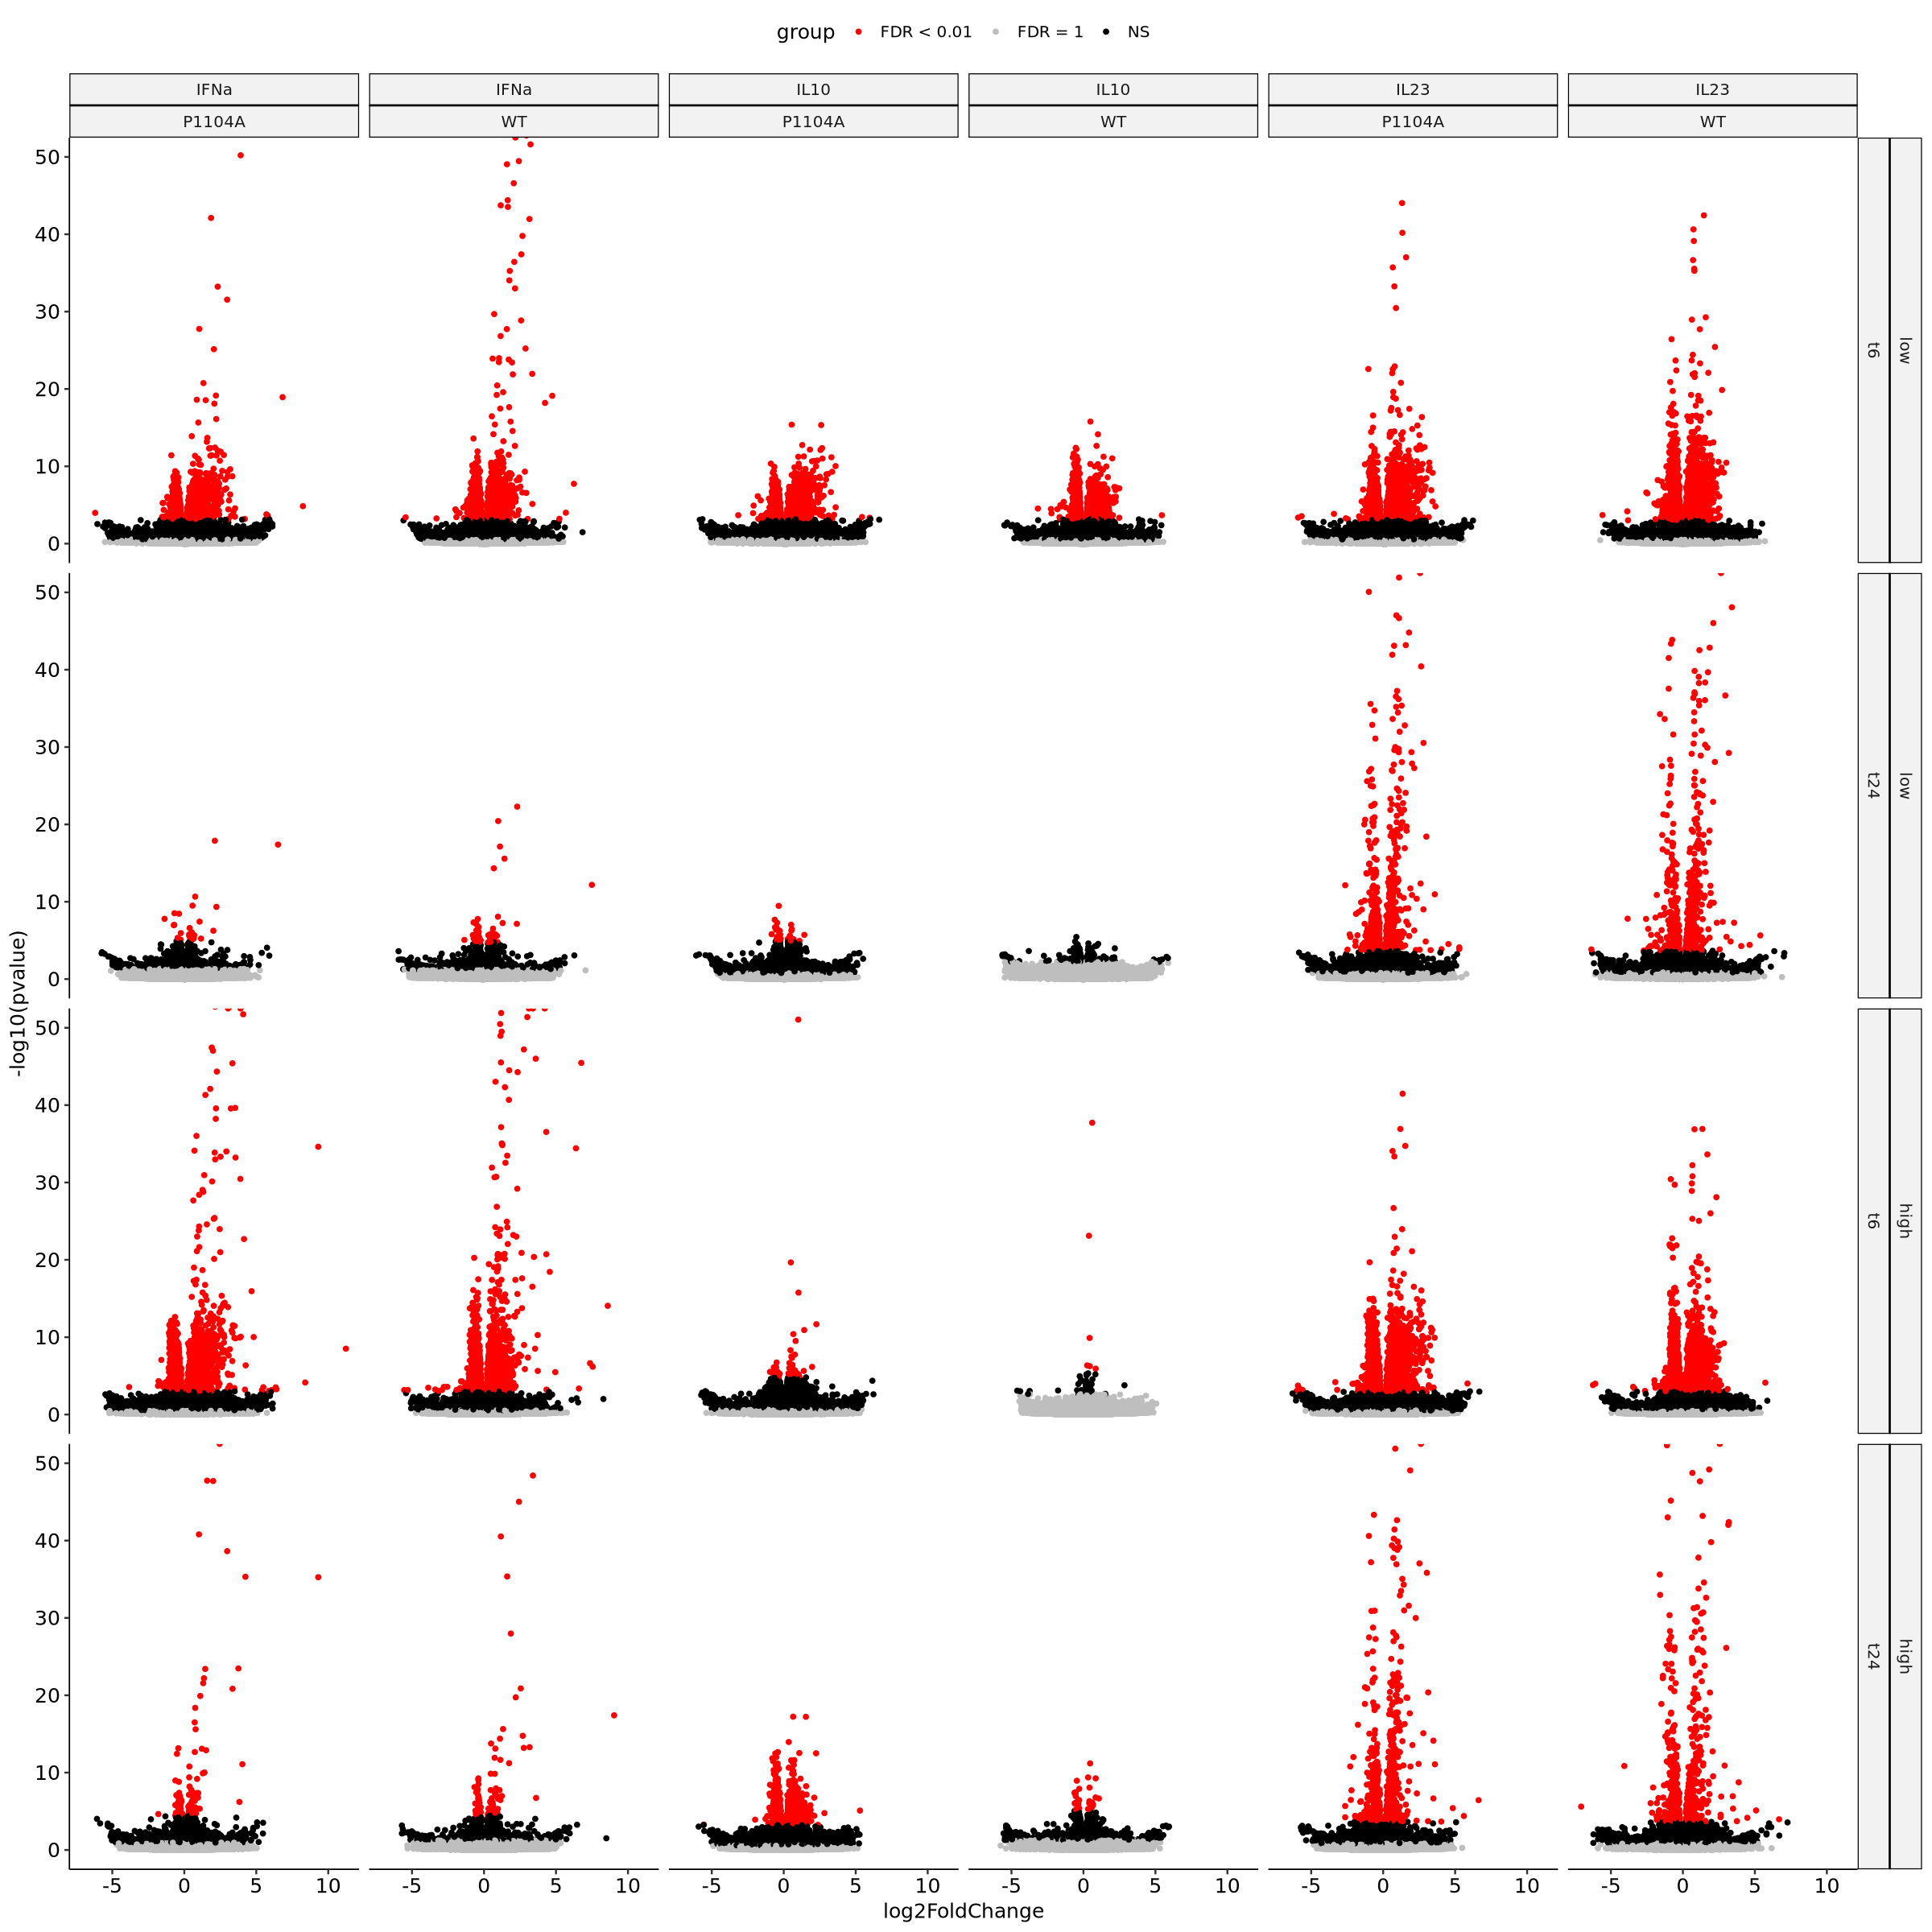

In [152]:
volcano_grid <- split_sumstats %>%
    ggplot() +
        geom_point(aes(x = log2FoldChange,
                       y = -log10(pvalue),
                       color = group)) +
        theme_pubr(base_size = 15) +
        facet_grid(rows = vars(dosage, time),
                   cols = vars(cytokine, background)) +
        scale_color_manual(values = c("FDR = 1" = "gray",
                                      "NS" = "black",
                                      "FDR < 0.01" = "red")) +
        coord_cartesian(ylim = c(0, 50))

options(repr.plot.width = 20, repr.plot.height = 20, warn = -1)
volcano_grid

background cytokine dosage time FDR < 0.01 vs Untreated
1  WT         IFNa     low    t6   2768                   
2  WT         IFNa     high   t6   3292                   
3  P1104A     IFNa     low    t6   2197                   
4  P1104A     IFNa     high   t6   3219                   
5  WT         IL10     low    t6   2357                   
6  WT         IL10     high   t6      6                   
7  P1104A     IL10     low    t6   2195                   
8  P1104A     IL10     high   t6     51                   
9  WT         IL23     low    t6   3492                   
10 WT         IL23     high   t6   3421                   
11 P1104A     IL23     low    t6   2865                   
12 P1104A     IL23     high   t6   3313                   
13 WT         IFNa     low    t24    58                   
14 WT         IFNa     high   t24   102                   
15 P1104A     IFNa     low    t24    30                   
16 P1104A     IFNa     high   t24   127                   
17 WT         IL10     low    t24     0                   
18 WT         IL10     high   t24    28                   
19 P1104A     IL10     low    t24    39                   
20 P1104A     IL10     high   t24  1904                   
21 WT         IL23     low    t24   736                   
22 WT         IL23     high   t24   696                   
23 P1104A     IL23     low    t24   800                   
24 P1104A     IL23     high   t24   782

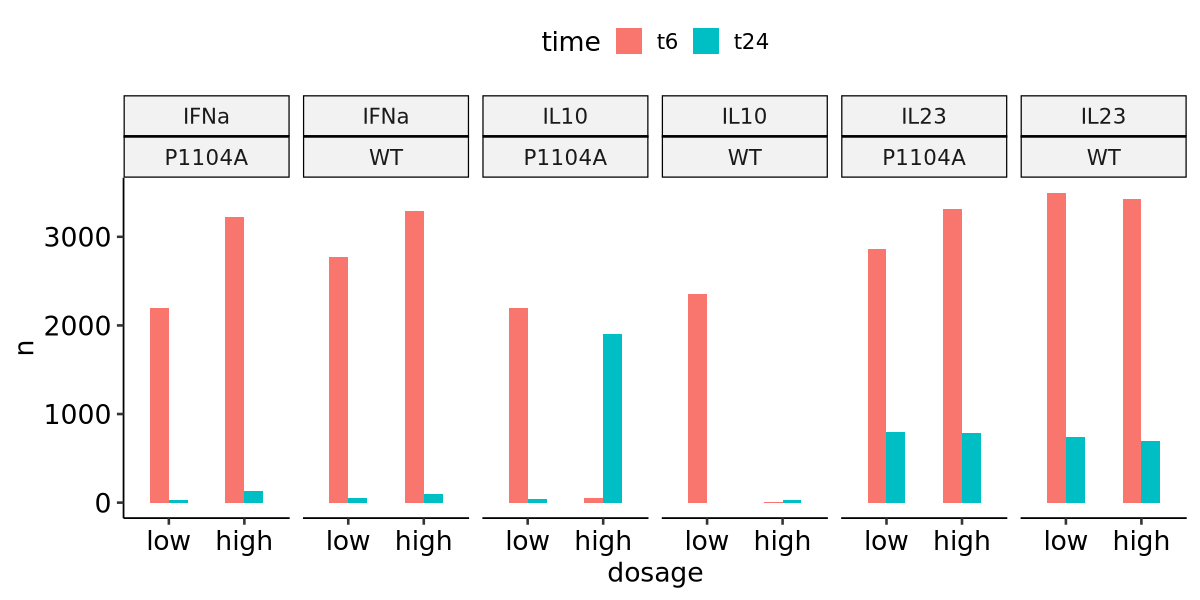

In [153]:
options(repr.plot.width = 10, repr.plot.height = 5)
split_sumstats  %>%
    filter(group == "FDR < 0.01") %>%
    group_by(background, cytokine, dosage, time) %>%
    count(group, .drop = FALSE) %>%
    ggplot() +
        geom_bar(aes(x = dosage,
                     y = n,
                     fill = time),
                 position = position_dodge(0.5),
                 width = 0.5,
                 stat = "identity")  +
        facet_grid(cols = vars(cytokine, background)) +
        theme_pubr(base_size = 16)

split_sumstats  %>%
    filter(group == "FDR < 0.01") %>%
    group_by(background, cytokine, dosage, time) %>%
    count(group, .drop = FALSE) %>%
    select(-group) %>%
    arrange(time, cytokine, rev(background), dosage) %>%
    rename("FDR < 0.01 vs Untreated" = "n")

#### Differentially Expressed Genes <a name="part4"></a>

In [165]:
vsd <- assay(vst(deresult, blind = FALSE))
vsd <- cbind(vsd, "row_var" = rowVars(vsd, na.rm = TRUE))

vsd_gene <- bind_cols("gene" = de_data$gene,
                      vsd) %>%
    pivot_longer(names_to = "sample", values_to = "norm_value", P1104A_IFNa_high_t24_1:WT_none_none_t6_4) %>%
    inner_join(de_prop %>% mutate(sample_id = str_c(covariate, "_", rep)),
               by = c("sample" = "sample_id")) %>%
    arrange(cytokine, group, dosage, time, rep)

var_genes <- vsd_gene %>%
    select(gene, row_var) %>%
    distinct() %>%
    arrange(-row_var) %>%
    head(500) %>%
    pull(gene)

vsd_gene_wide_sig <- vsd_gene %>%
    filter(gene %in% var_genes) %>%
    mutate(sample_name = str_c(cytokine, " ", dosage, " ", group, " ", time, " ", rep)) %>%
    select(gene, sample_name, norm_value) %>%
    pivot_wider(names_from = sample_name, values_from = norm_value)

vsd_gene_wide_all <- vsd_gene %>%
    mutate(sample_name = str_c(cytokine, " ", dosage, " ", group, " ", time, " ", rep)) %>%
    select(gene, sample_name, norm_value) %>%
    pivot_wider(names_from = sample_name, values_from = norm_value)

In [167]:
vsd_format <- vsd_gene_wide_all
names(vsd_format)[-1] <- gsub(" ", "_", names(vsd_format)[-1])
vsd_format %>% write_tsv("../sumstats/RNASEQ/run3/deseq2-variance-stabilized-quants.tsv")

Loading required namespace: magick



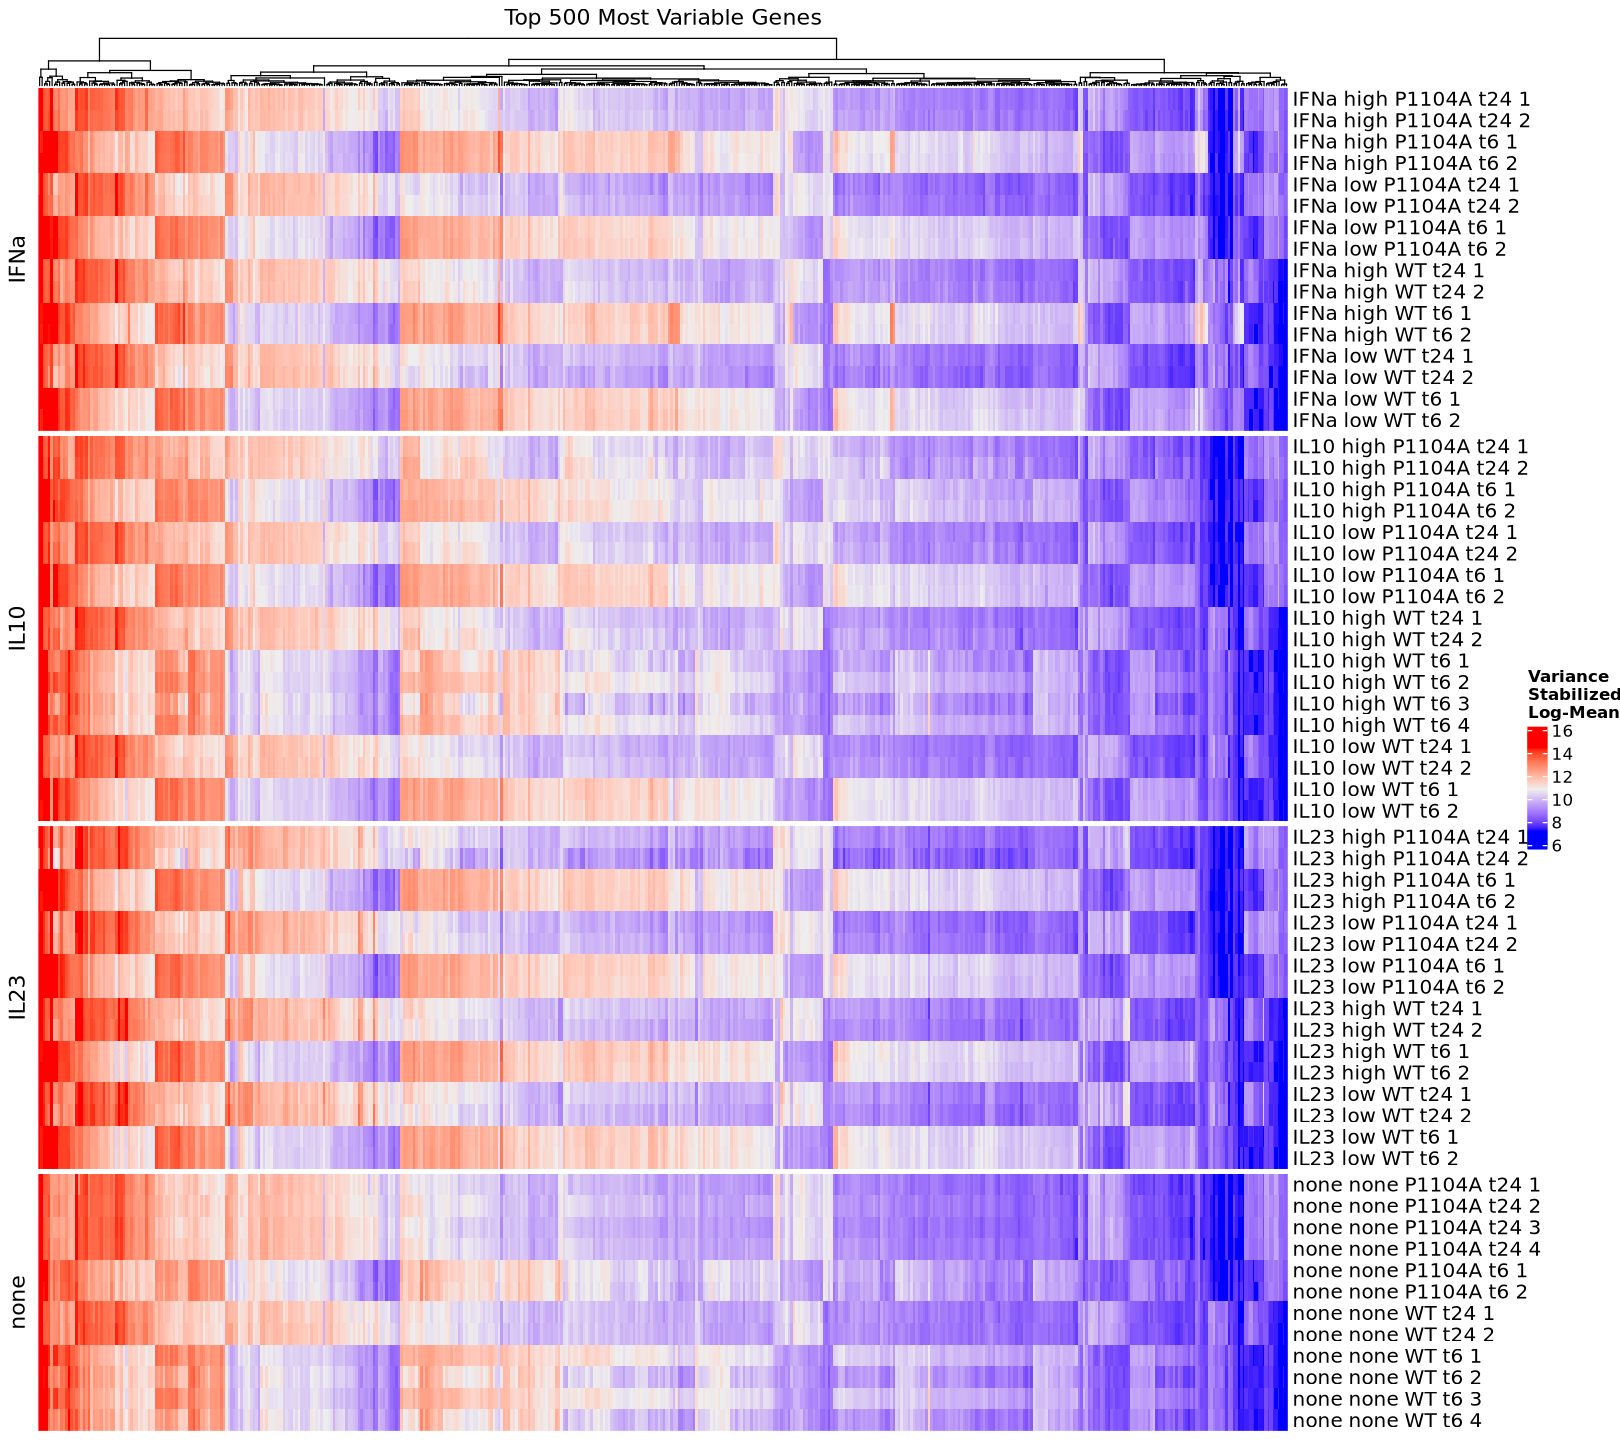

In [168]:
options(repr.plot.width = 13.5, repr.plot.height = 12)
Heatmap(t(as.matrix(vsd_gene_wide_sig[,-1])),
        column_title = "Top 500 Most Variable Genes",
        cluster_columns = TRUE,
        cluster_rows = FALSE,
        row_split = gsub(" .*", "", names(vsd_gene_wide_sig[,-1])),
        use_raster = TRUE,
        raster_by_magick = TRUE,
        name = "Variance\nStabilized\nLog-Mean")

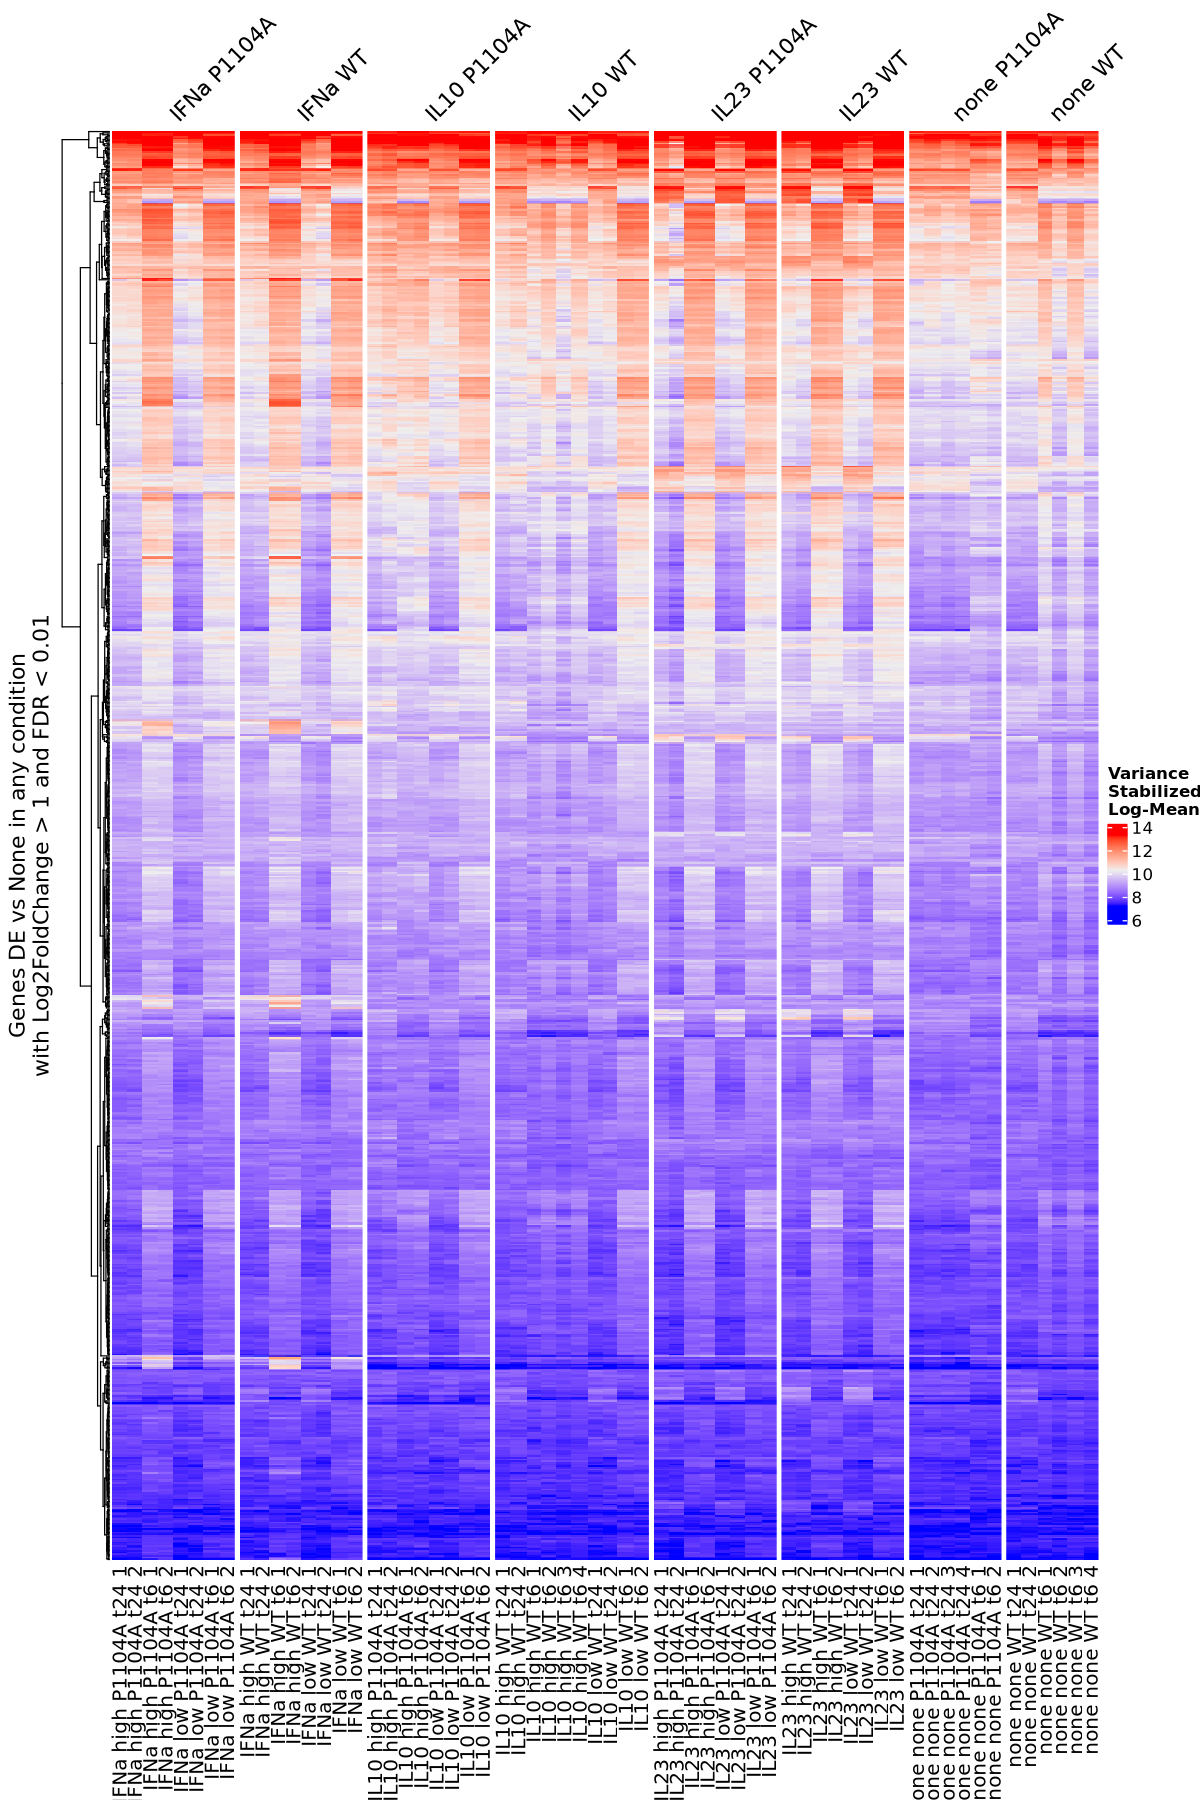

In [170]:
de_genes_sig <- split_sumstats %>%
    filter(log2FoldChange > 1, padj < 0.01, !grepl("ENSG", gene)) %>%
    pull(gene) %>%
    unique()

heat_genes_wide <- vsd_gene_wide_all[vsd_gene_wide_all$gene %in% de_genes_sig,]
heat_data <- t(as.matrix(heat_genes_wide[,-1]))
colnames(heat_data) <- unlist(heat_genes_wide[,1])

options(repr.plot.width = 10, repr.plot.height = 15)
Heatmap(t(heat_data),show_row_names = FALSE,
        cluster_columns = FALSE,
        cluster_rows = TRUE,
        column_split = gsub("low |high |t6|t24| 1| 2| 3| 4| none", "", colnames(heat_genes_wide[,-1])),
        use_raster = TRUE,
        column_title_rot = 45,
        name = "Variance\nStabilized\nLog-Mean",
        row_title = "Genes DE vs None in any condition\nwith Log2FoldChange > 1 and FDR < 0.01")

#### Gene Visualizations <a name="part5"></a>

In [171]:
plot_gene <- function(gene_id) {

    the_plot <- split_sumstats %>%
        filter(gene == gene_id) %>%
        mutate(dosage = relevel(as.factor(dosage), ref = "low")) %>%
        ggplot() +
            geom_pointrange(aes(x = dosage,
                                y = log2FoldChange,
                                ymin = log2FoldChange - 2*lfcSE,
                                ymax = log2FoldChange + 2*lfcSE,
                                color = time), position = position_dodge(width = 0.4)) +
            theme_pubr(base_size = 16,
                       x.text.angle = 45) +
            ggtitle(gene_id) +
            geom_hline(yintercept = 0) +
            facet_grid(cols = vars(cytokine, background))

    return(the_plot)
    
}


stat1 <- plot_gene("STAT1")
stat2 <- plot_gene("STAT2")
stat3 <- plot_gene("STAT3")

jak1 <- plot_gene("JAK1")
jak2 <- plot_gene("JAK2")
jak3 <- plot_gene("JAK3")

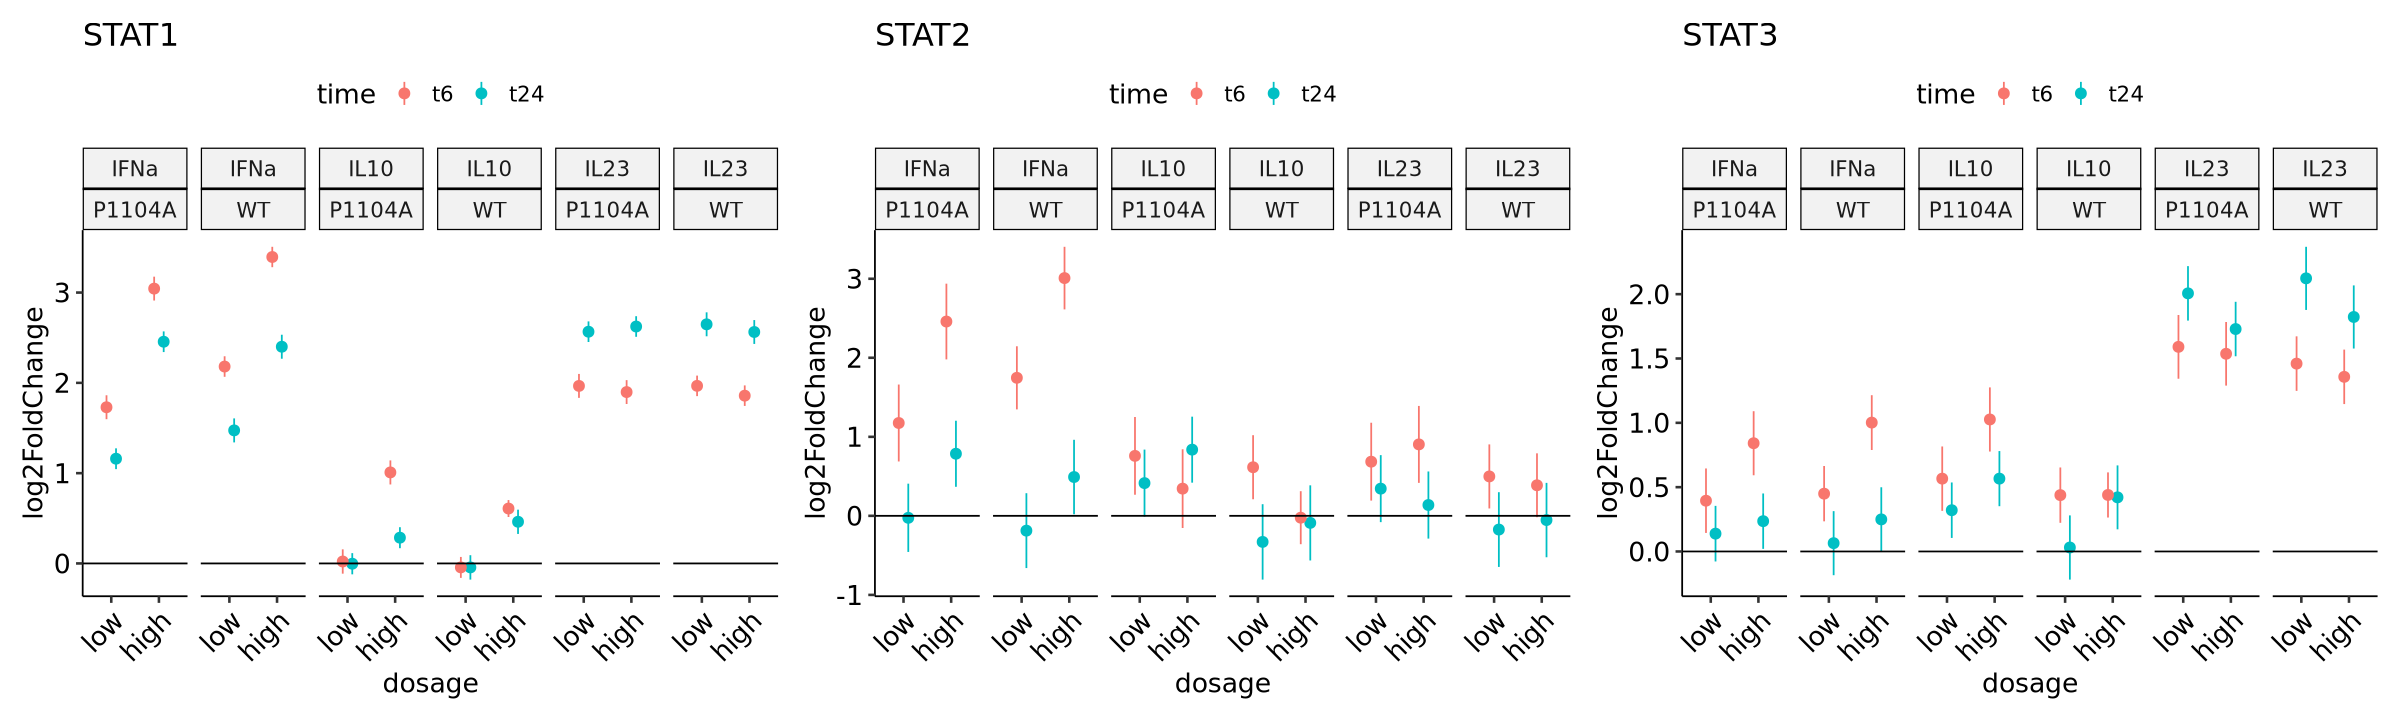

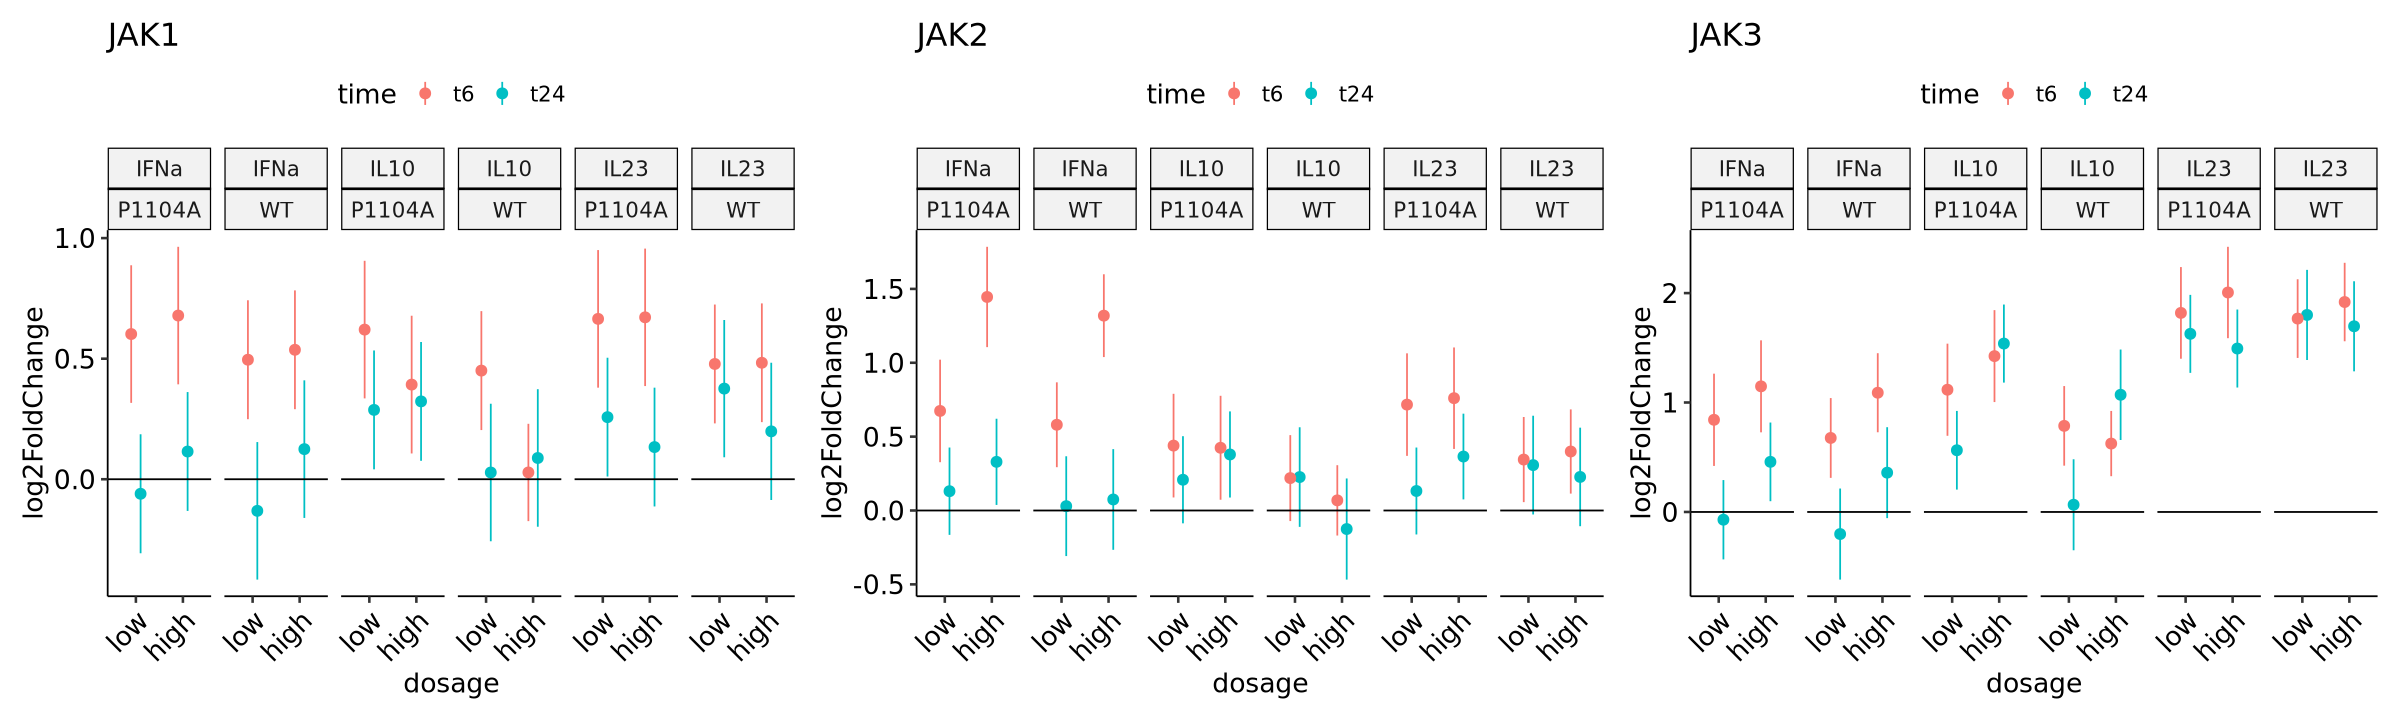

In [172]:
options(repr.plot.width = 20, repr.plot.height = 6)
stat1 + stat2 + stat3
jak1 + jak2 + jak3

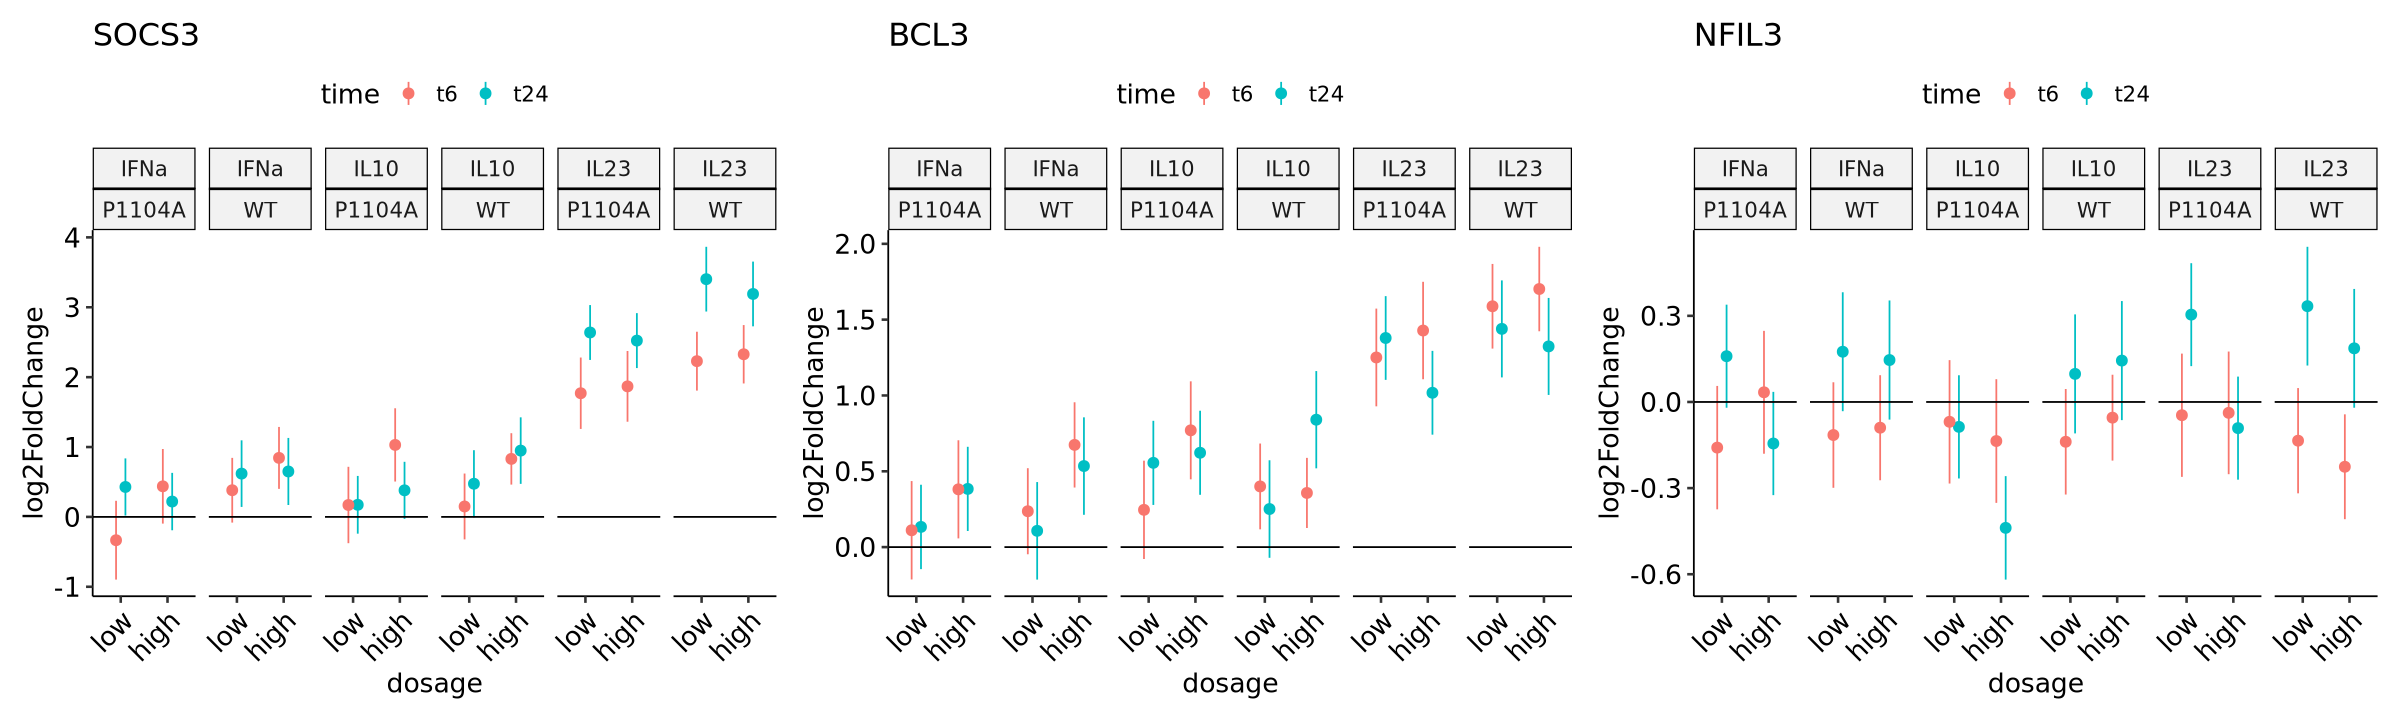

In [173]:
options(repr.plot.width = 20, repr.plot.height = 6)
plot_gene("SOCS3") + 
    plot_gene("BCL3") +
    plot_gene("NFIL3")

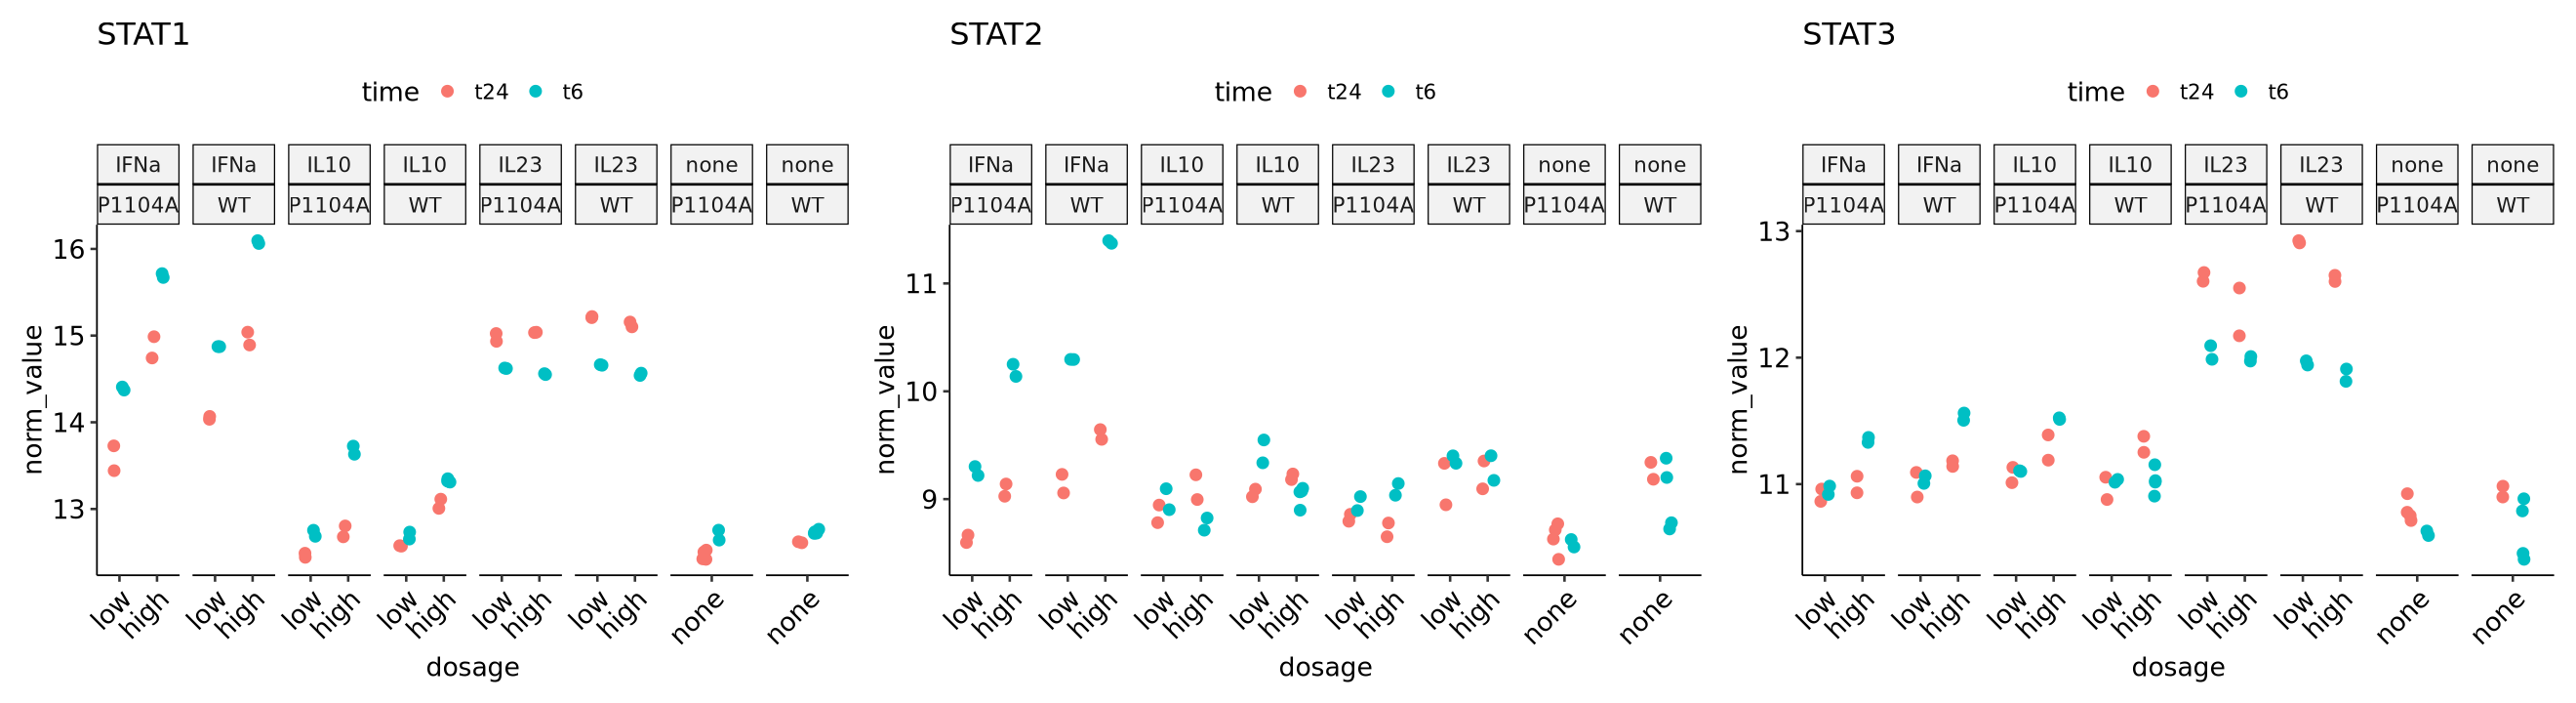

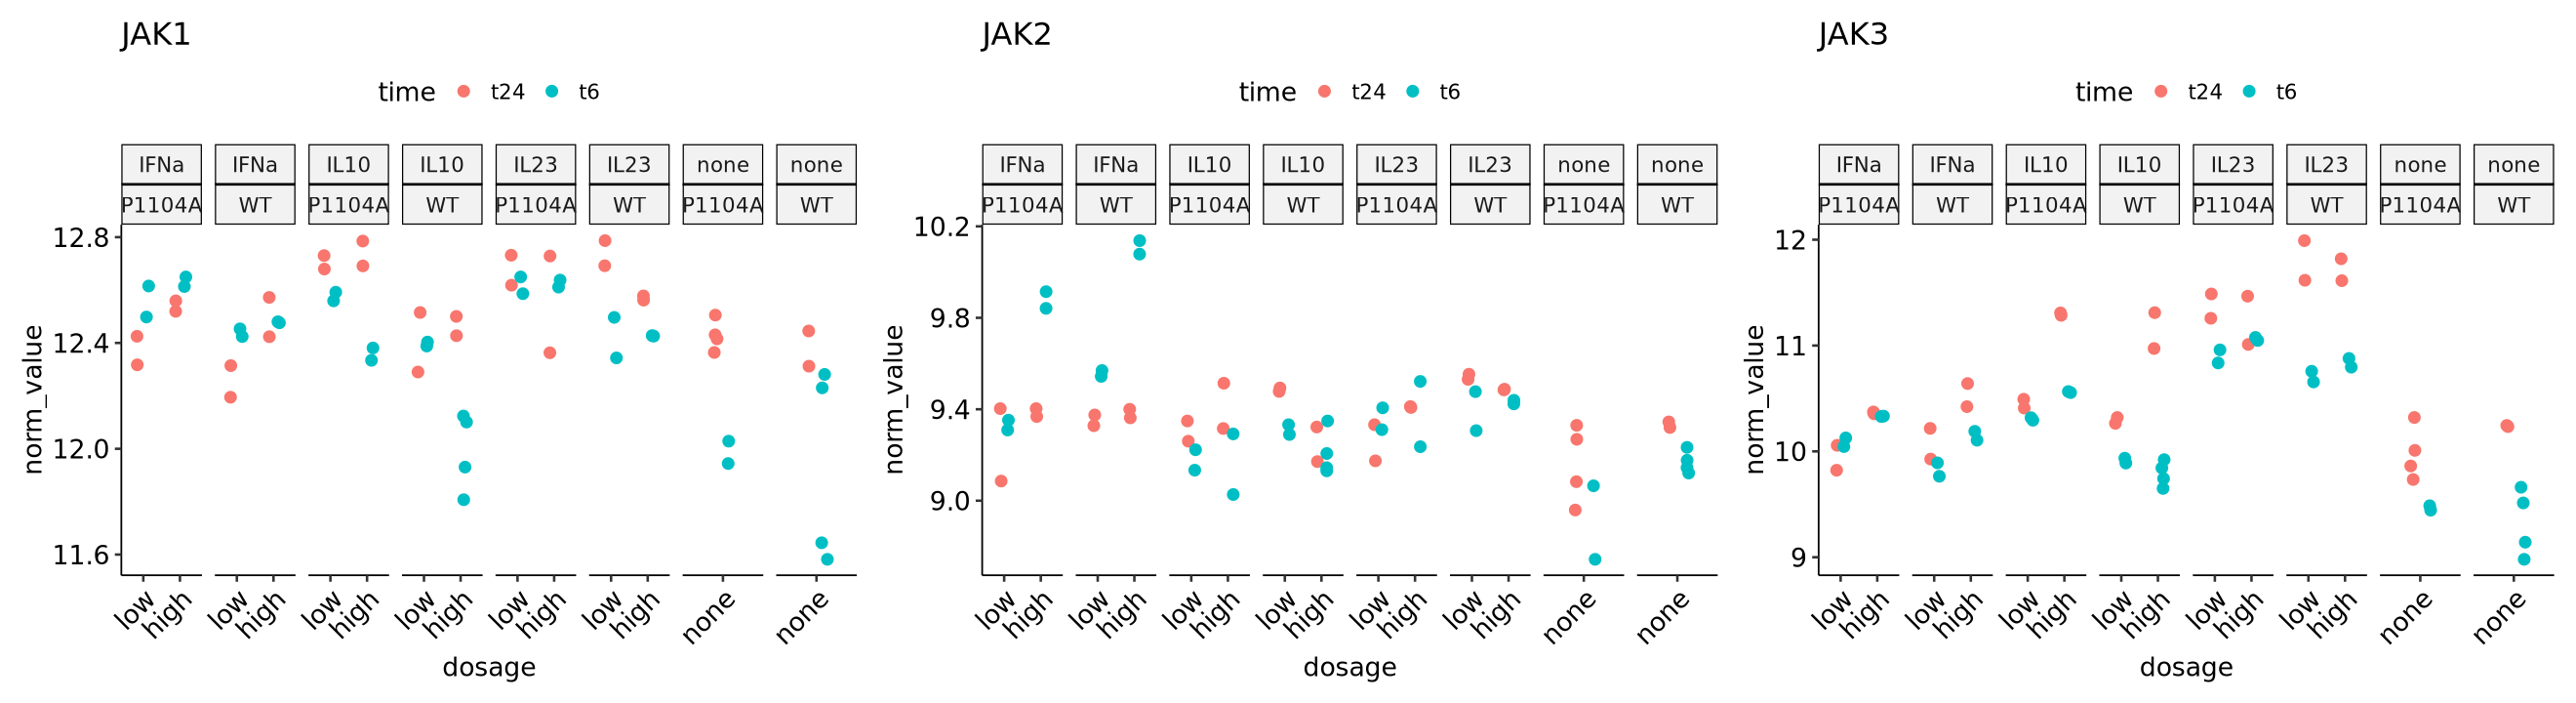

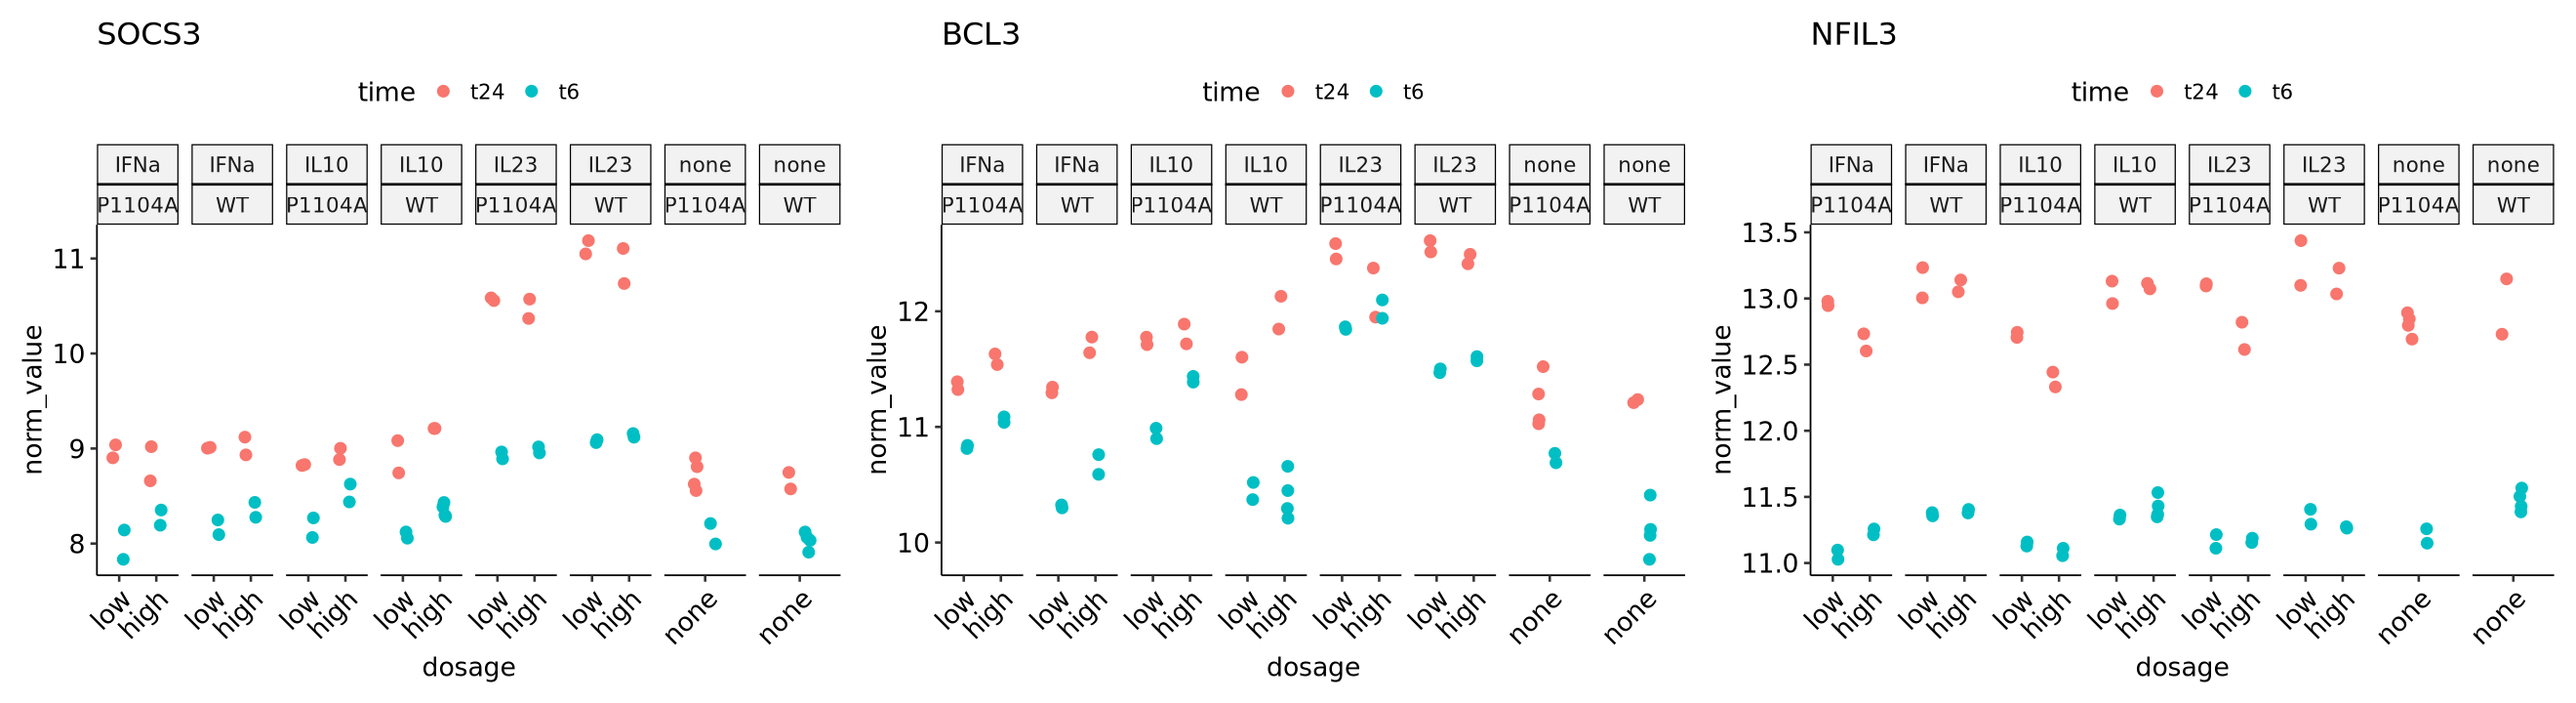

In [179]:
plot_gene_vsd <- function(gene_id) {

    the_plot <- vsd_gene %>%
        filter(gene == gene_id) %>%
        mutate(dosage = relevel(as.factor(dosage), ref = "low")) %>%
        ggplot() +
            geom_point(aes(x = dosage,
                           y = norm_value,
                           color = time),
                       size = 3,
                       position = position_jitterdodge(jitter.width = 0.1,
                                                       dodge.width = 0.5)) +
            theme_pubr(base_size = 16,
                       x.text.angle = 45) +
            ggtitle(gene_id) +
            facet_grid(cols = vars(cytokine, group), scales = "free_x")

    return(the_plot)
    
}

options(repr.plot.width = 22, repr.plot.height = 6)
plot_gene_vsd("STAT1") + 
    plot_gene_vsd("STAT2") +
    plot_gene_vsd("STAT3")
plot_gene_vsd("JAK1") + 
    plot_gene_vsd("JAK2") +
    plot_gene_vsd("JAK3")
plot_gene_vsd("SOCS3") + 
    plot_gene_vsd("BCL3") +
    plot_gene_vsd("NFIL3")

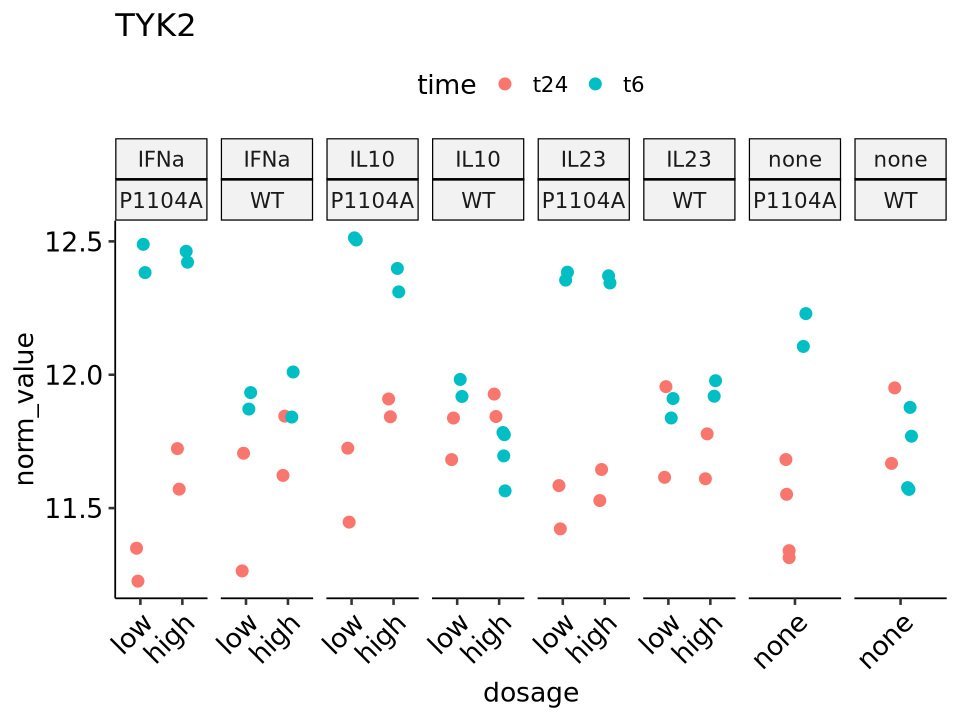

In [178]:
options(repr.plot.width = 8, repr.plot.height = 6)
plot_gene_vsd("TYK2")